In [1]:
import numpy as np
import pandas as pd

from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.inference.mrash_wrapR          import MrASHR
from mrashpen.models.plr_ash                 import PenalizedMrASH
from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled
from mrashpen.inference.ebfit                import ebfit
from mrashpen.inference.lbfgsfit             import lbfgsfit
from mrashpen.utils                          import R_lasso
from mrashpen.inference                      import elbo as elbo_py
from mrashpen.inference                      import coordinate_descent_step as cd_step

import sys
sys.path.append('/home/saikat/Documents/work/sparse-regression/simulation/eb-linreg-dsc/dsc/functions')
import simulate

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')


def center_and_scale(Z):
    dim = Z.ndim
    if dim == 1:
        Znew = Z / np.std(Z)
        Znew = Znew - np.mean(Znew)
    elif dim == 2:
        Znew = Z / np.std(Z, axis = 0)
        Znew = Znew - np.mean(Znew, axis = 0).reshape(1, -1)
    return Znew

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

def plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, bhat, 
                         intercept = 0, title = None):
    ypred = np.dot(Xtest, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(ytest, ypred, s = 2, alpha = 0.5)
    mpl_utils.plot_diag(ax1)
    ax2.scatter(btrue, bhat)
    mpl_utils.plot_diag(ax2)

    ax1.set_xlabel("Y_test")
    ax1.set_ylabel("Y_predicted")
    ax2.set_xlabel("True b")
    ax2.set_ylabel("Predicted b")
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    
    
def plot_convergence(objs, methods, nwarm, eps = 1e-8):
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(111)

    objmin  = np.min([np.min(x) for x in objs])

    for obj, method, iteq in zip(objs, methods, nwarm):
        m_obj = obj[iteq:] - objmin
        m_obj = m_obj[m_obj > 0]
        ax1.plot(range(iteq, len(m_obj) + iteq), np.log10(m_obj), label = method, 
                 marker = 'o', markersize = 1)
    ax1.legend()

    ax1.set_xlabel("Number of Iterations")
    ax1.set_ylabel("log( max(ELBO) - ELBO )")

    plt.show()
    return

def plot_trendfilter_mrashpen(X, y, beta, ytest, bhat,
                              intercept = 0, title = None):
    n = y.shape[0]
    p = X.shape[1]

    ypred = np.dot(X, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(np.arange(n), ytest, edgecolor = 'black', facecolor='white')
    ax1.plot(np.arange(n), ypred)
    ax1.set_xlabel("Sample index")
    ax1.set_ylabel("Y")

    ax2.scatter(np.arange(p), beta, edgecolor = 'black', facecolor = 'white')
    ax2.scatter(np.arange(p), bhat, s = 40, color = 'firebrick')
    ax2.set_xlabel("Sample index")
    ax2.set_ylabel("b")
    
    if title is not None:
        fig.suptitle(title)

    plt.tight_layout()
    plt.show()
    
def linreg_summary_df(sigma2, objs, methods):
    data     = [[strue * strue,  '-', '-']]
    rownames = ['True']
    for obj, method in zip(objs, methods):
        data.append([obj.residual_var, obj.elbo_path[-1], obj.niter])
        rownames.append(method)
    colnames = ['sigma2', 'ELBO', 'niter']
    df = pd.DataFrame.from_records(data, columns = colnames, index = rownames)
    return df

def linreg_summary_df_noelbo(sigma2, objs, methods):
    data     = [[strue * strue, '-']]
    rownames = ['True']
    for obj, method in zip(objs, methods):
        data.append([obj.residual_var, obj.niter])
        rownames.append(method)
    colnames = ['sigma2', 'niter']
    df = pd.DataFrame.from_records(data, columns = colnames, index = rownames)
    return df

def get_elbos(X, y, b, w, sk, s2):
    elbo1 = cd_step.elbo(X, y, sk, b, w, s2)

    dj     = np.sum(np.square(X), axis = 0)
    r      = y - np.mean(y) - np.dot(X, b)
    btilde = b + np.dot(X.T, r) / dj
    nmash  = NormalMeansASHScaled(btilde, np.sqrt(s2), w, sk, d = dj, debug = False)
    phijk, mujk, varjk = nmash.posterior()
    elbo2  = elbo_py.scalemix(X, y, sk, b, w, s2,
                              dj = dj, phijk = phijk, mujk = mujk, varjk = varjk, eps = 1e-8)
    return elbo1, elbo2

In [2]:
n = 200
p = 2000
p_causal = 10
pve = 0.95
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = 0.95, seed = 10)
X      = center_and_scale(X)
Xtest  = center_and_scale(Xtest)
wk, sk = initialize_ash_prior(k, scale = 2)

In [3]:
'''
Lasso initialization
'''
lasso_a0, lasso_b, _ = R_lasso.fit(X, y)
s2init = np.var(y - np.dot(X, lasso_b) - lasso_a0)

'''
mr.ash.pen
'''
# plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = False, is_prior_scaled = True,
#                 debug = False, display_progress = False, calculate_elbo = True, maxiter = 2000)
# plr_lbfgs.fit(X, y, sk, binit = None, winit = wk, s2init = s2init)
plr_lbfgs = lbfgsfit(X, y, sk, wk, binit = lasso_b, s2init = s2init, calculate_elbo = True)


'''
mr.ash.pen (EM)
'''
plr_eb = ebfit(X, y, sk, wk, binit = lasso_b, s2init = 1, maxiter = 200, qb_maxiter = 100)

'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(X, y, sk, binit = lasso_b, winit = wk, s2init = 1)


'''
mr.ash.alpha (init)
'''
mrash_r_init = MrASHR(option = "r2py", debug = False)
mrash_r_init.fit(X, y, sk, binit = plr_lbfgs.coef, winit = plr_lbfgs.prior, s2init = plr_lbfgs.residual_var)

R[write to console]: Loading required package: Matrix



mr.ash.pen terminated at iteration 1780.
mr.ash.pen terminated at iteration 9.
mr.ash.pen terminated at iteration 33.
mr.ash.pen terminated at iteration 1232.
mr.ash.pen (EM) terminated at iteration 200.
Mr.ASH terminated at iteration 348.
Mr.ASH terminated at iteration 12.


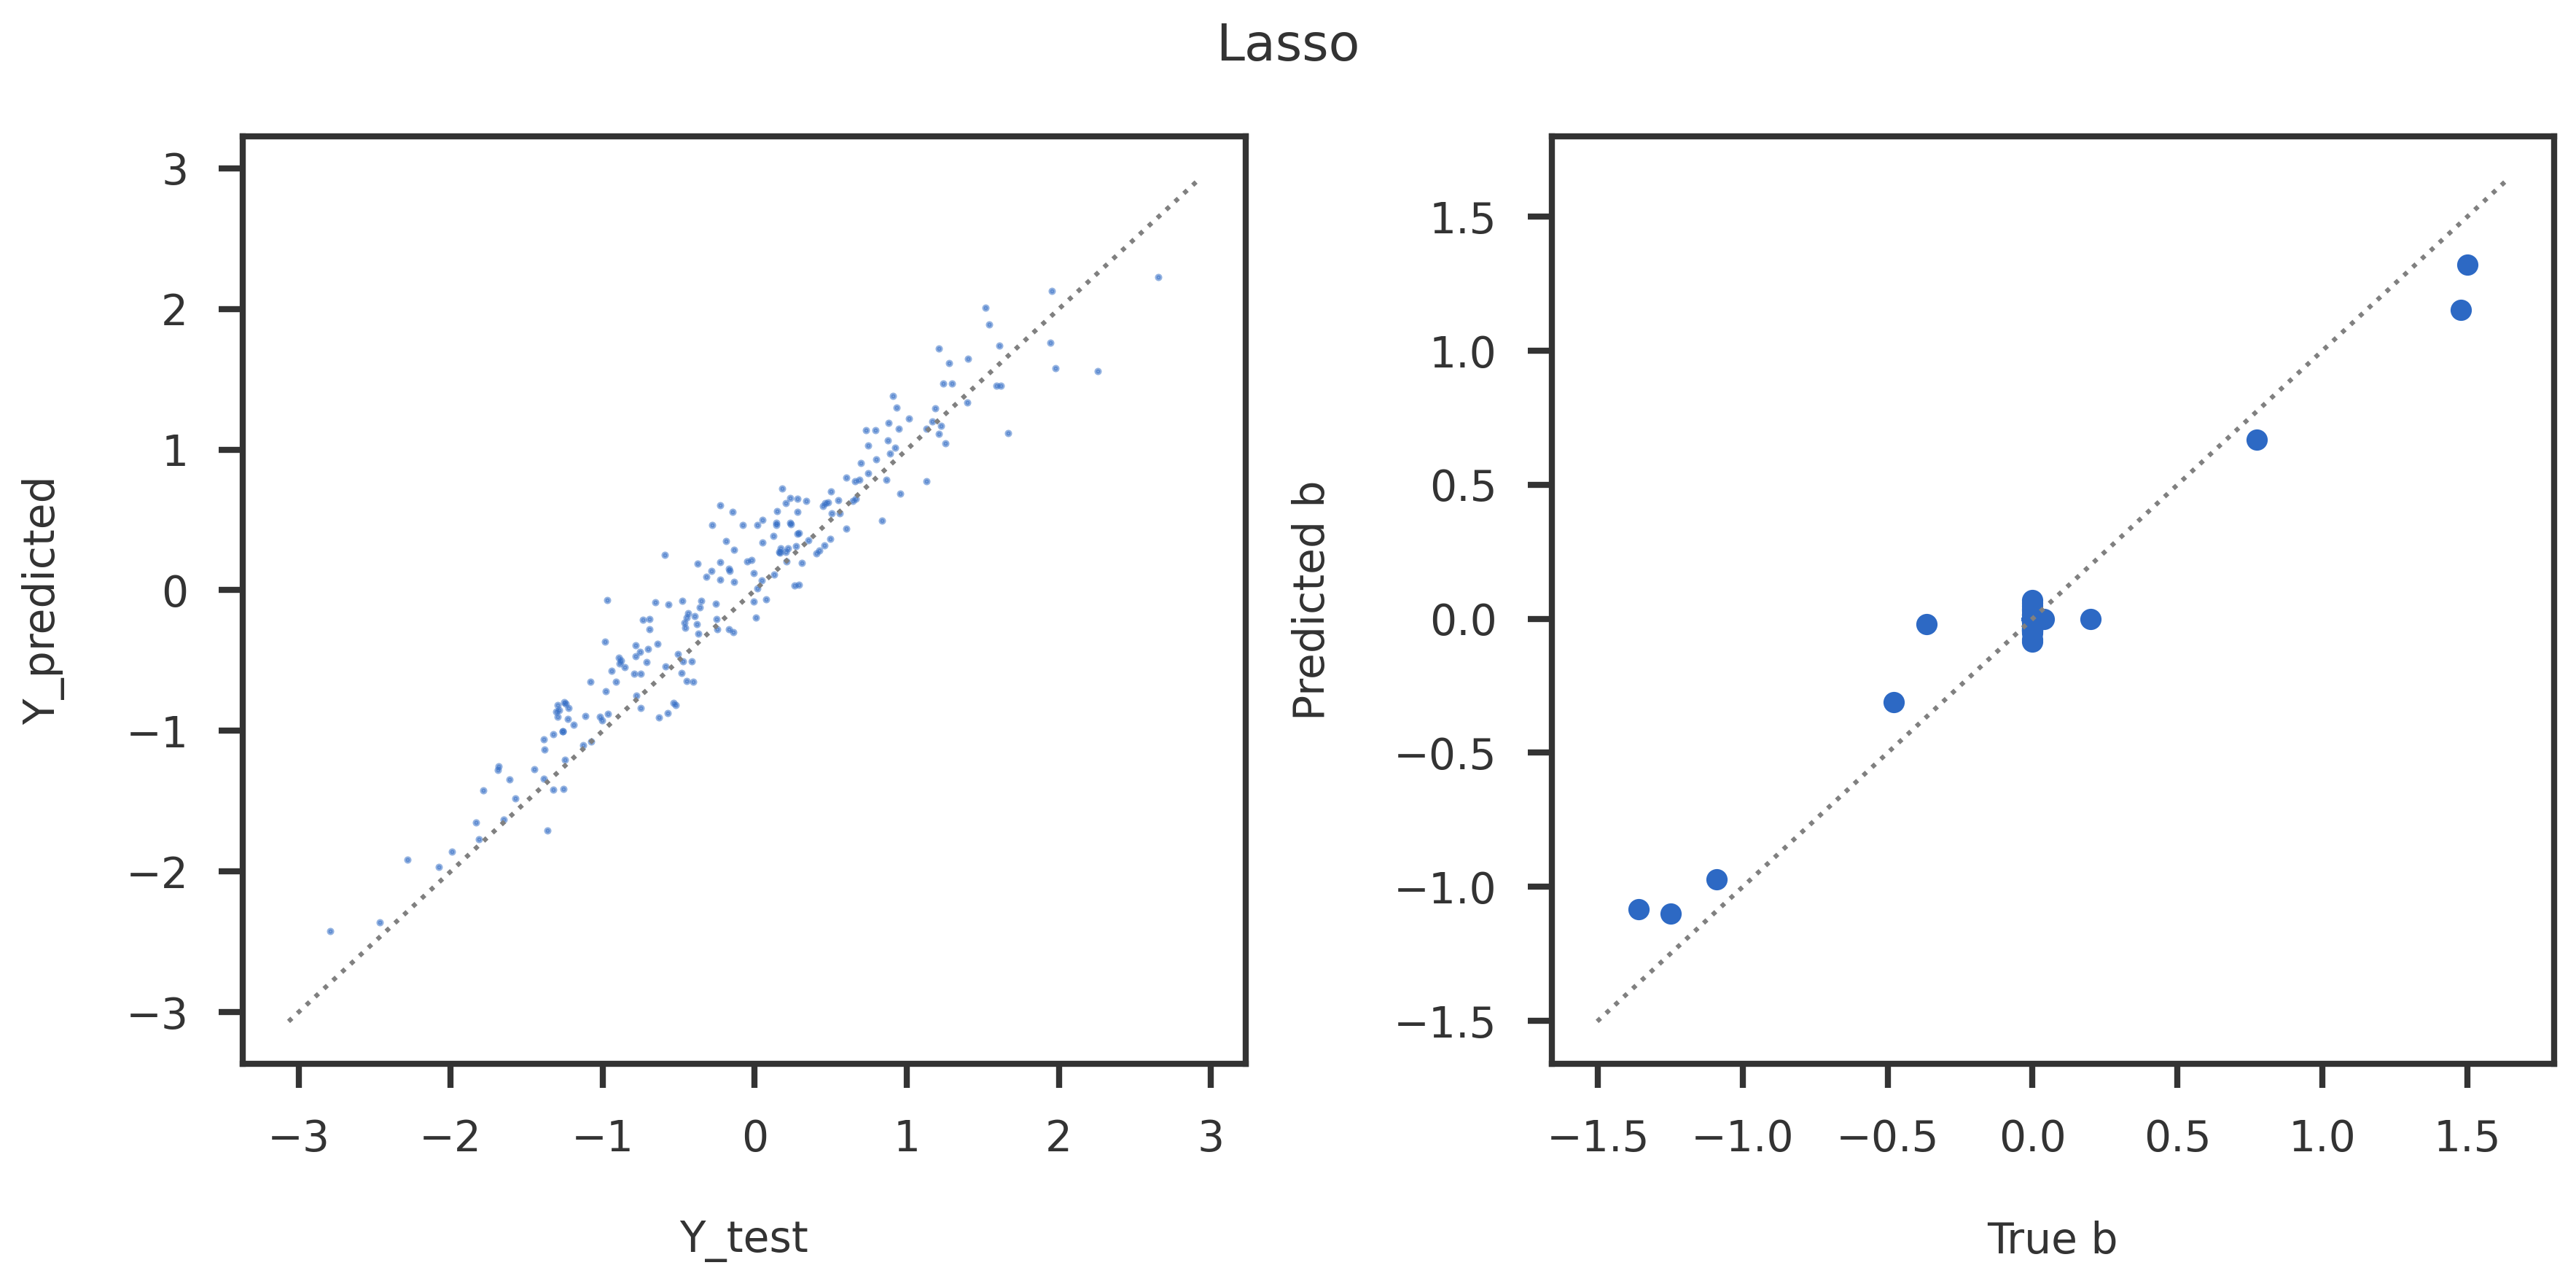

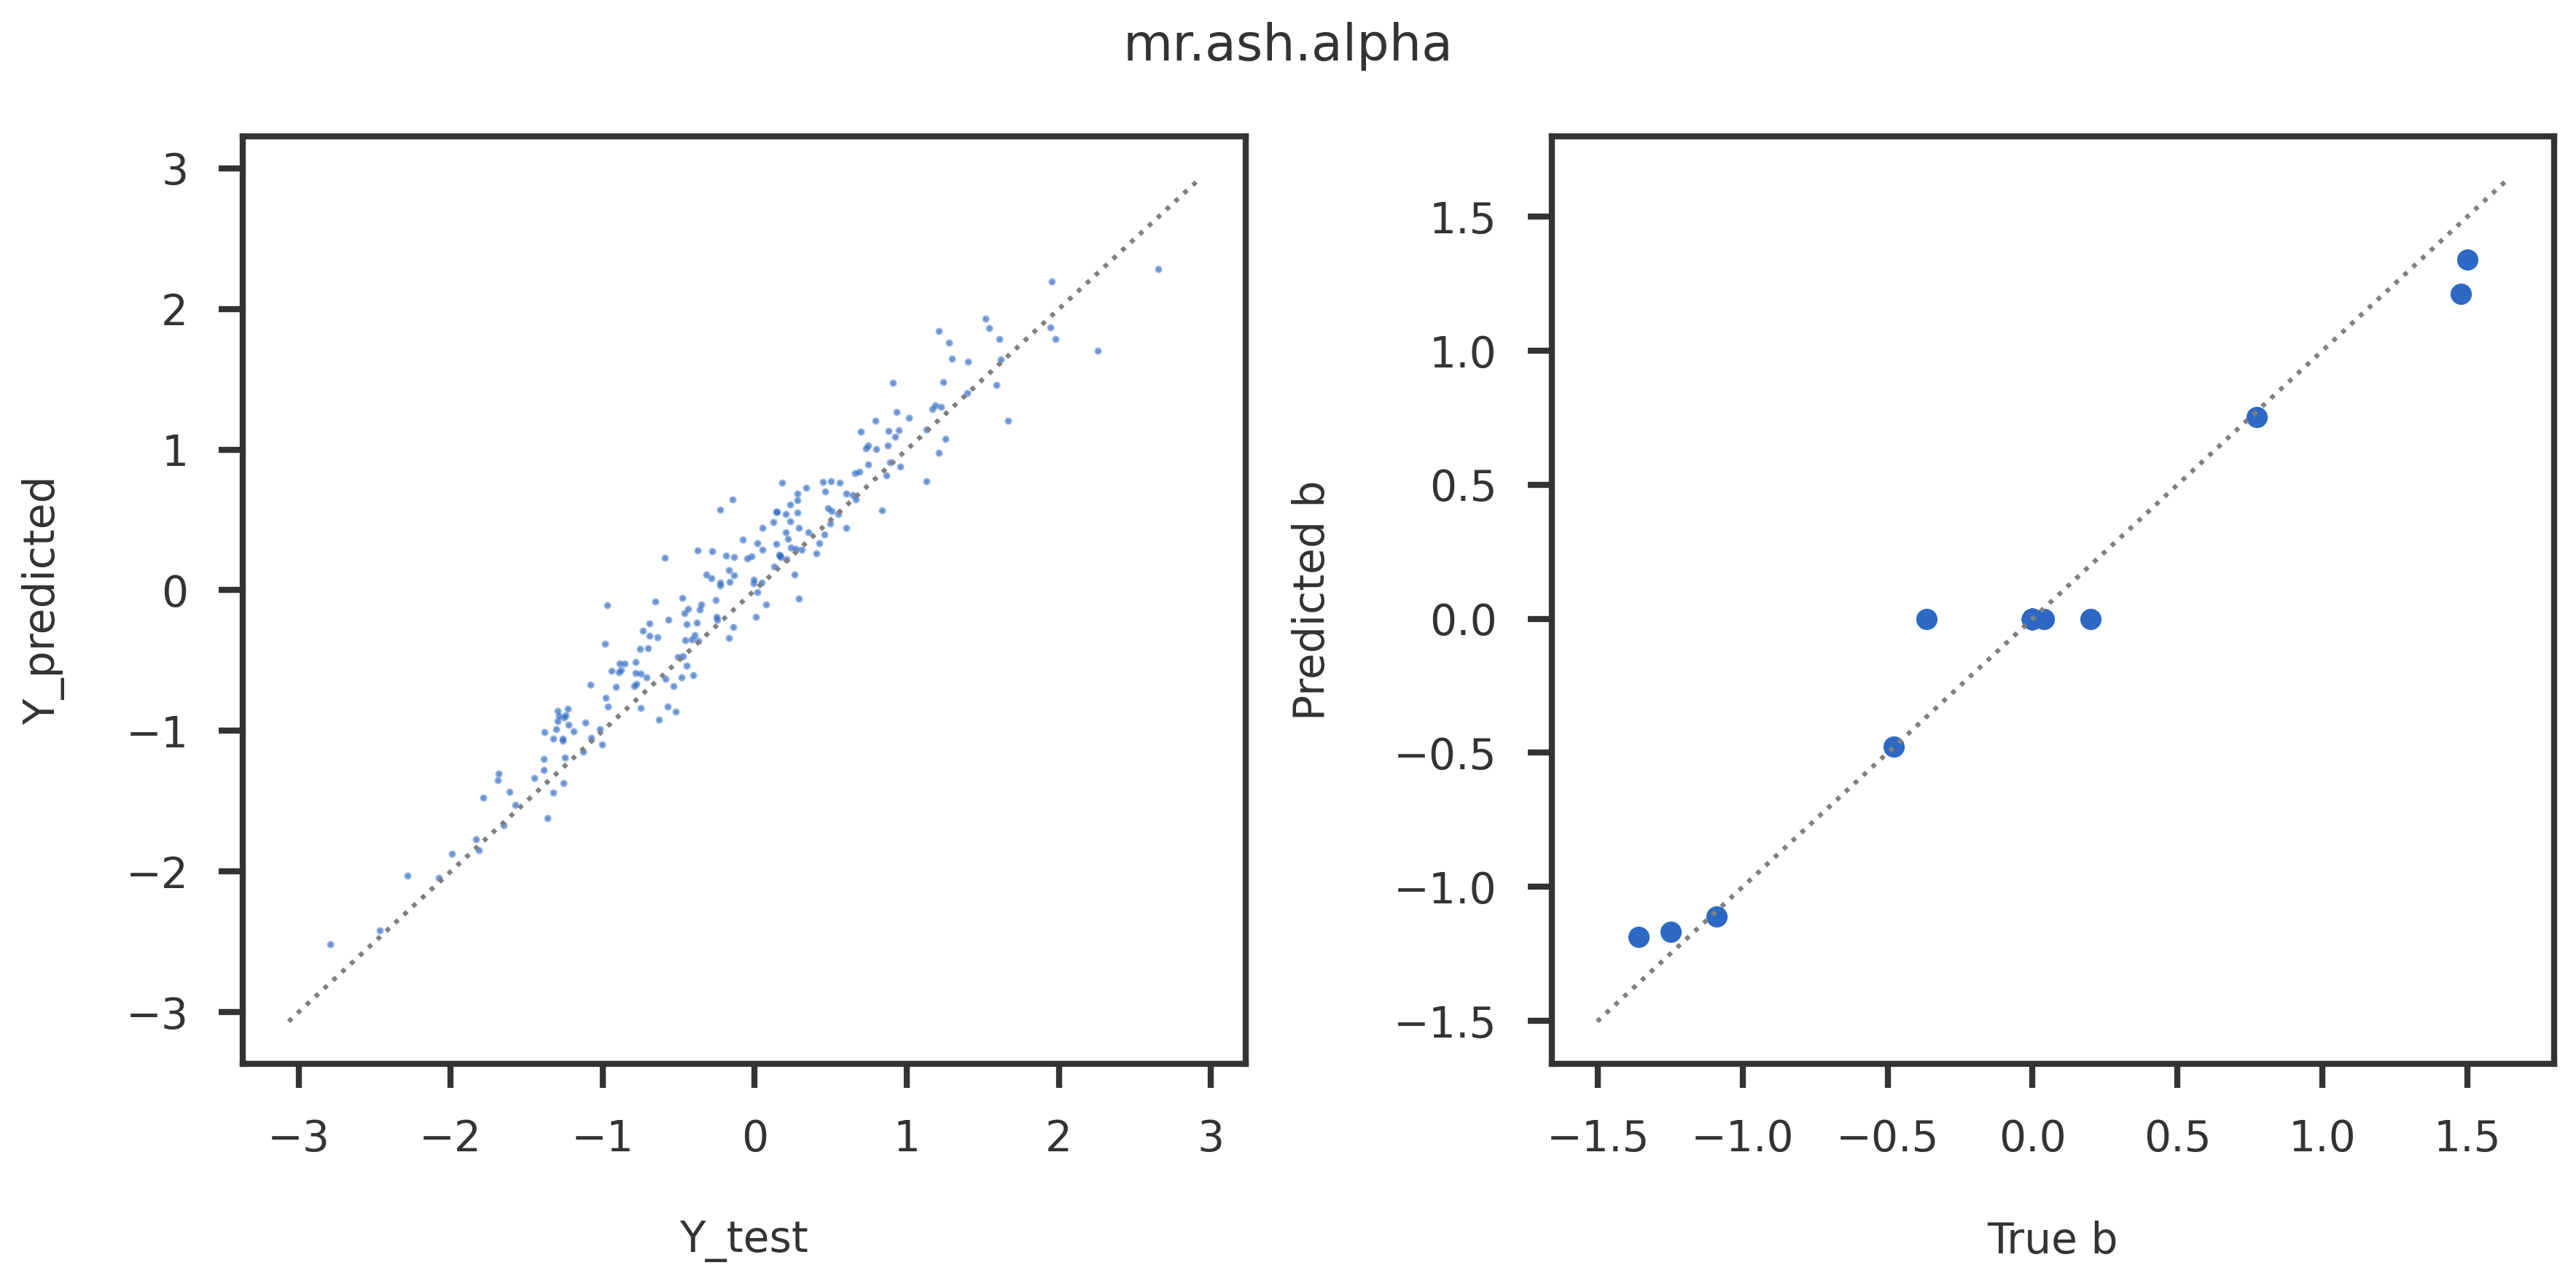

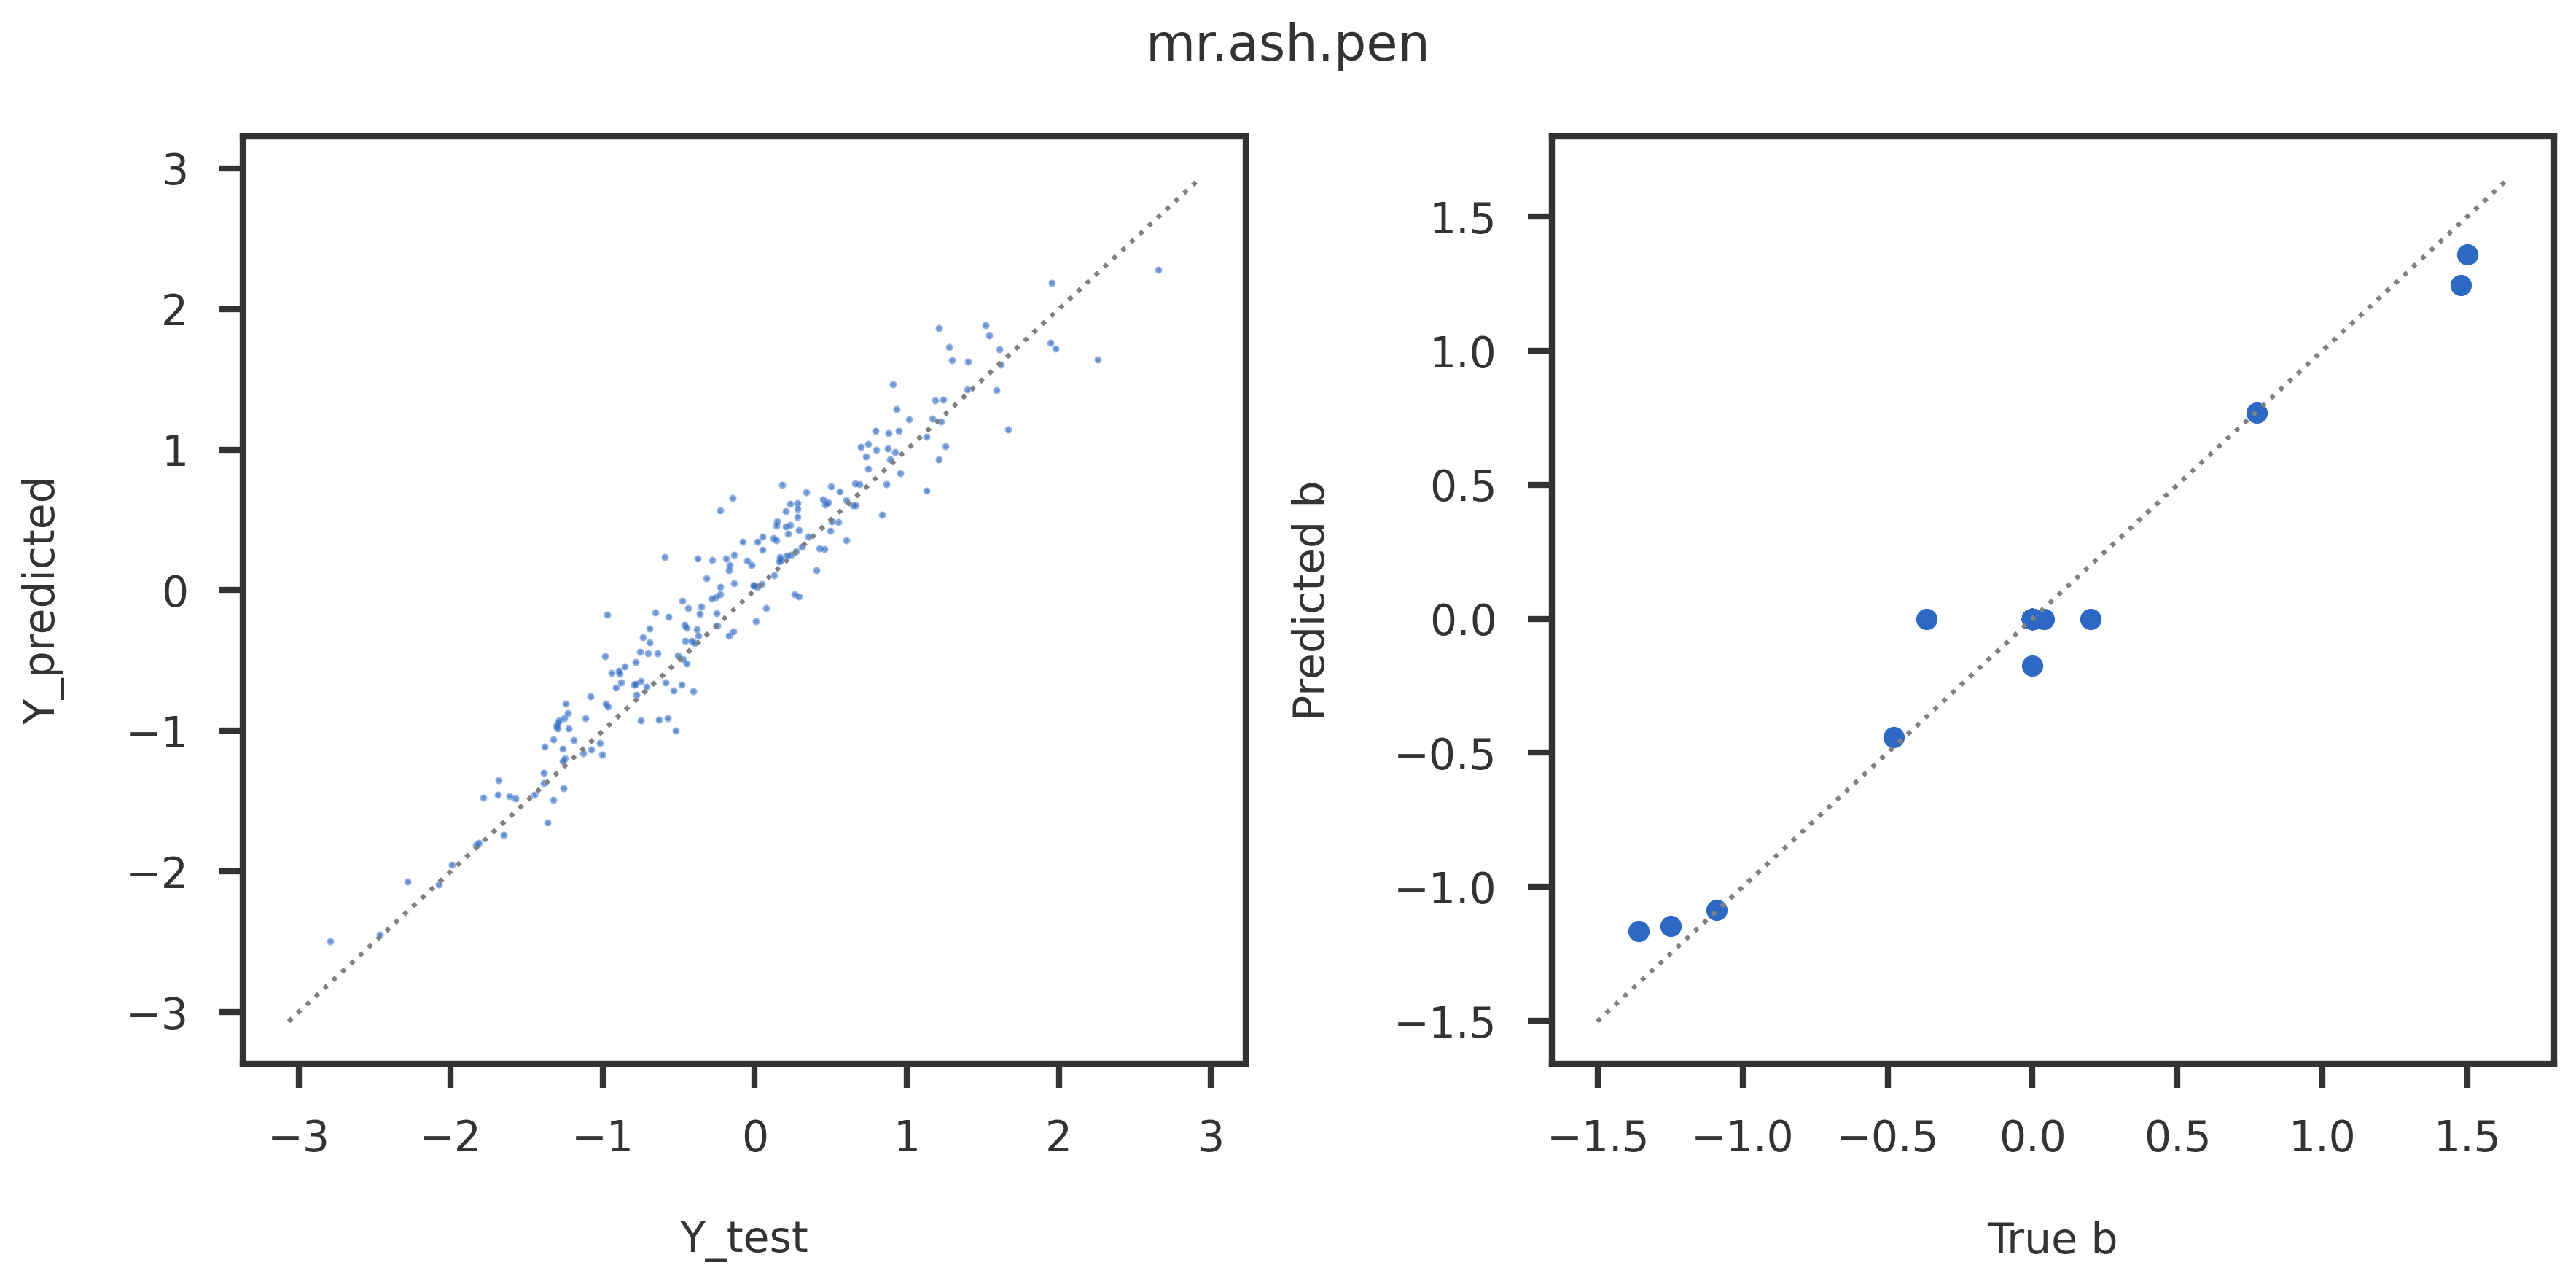

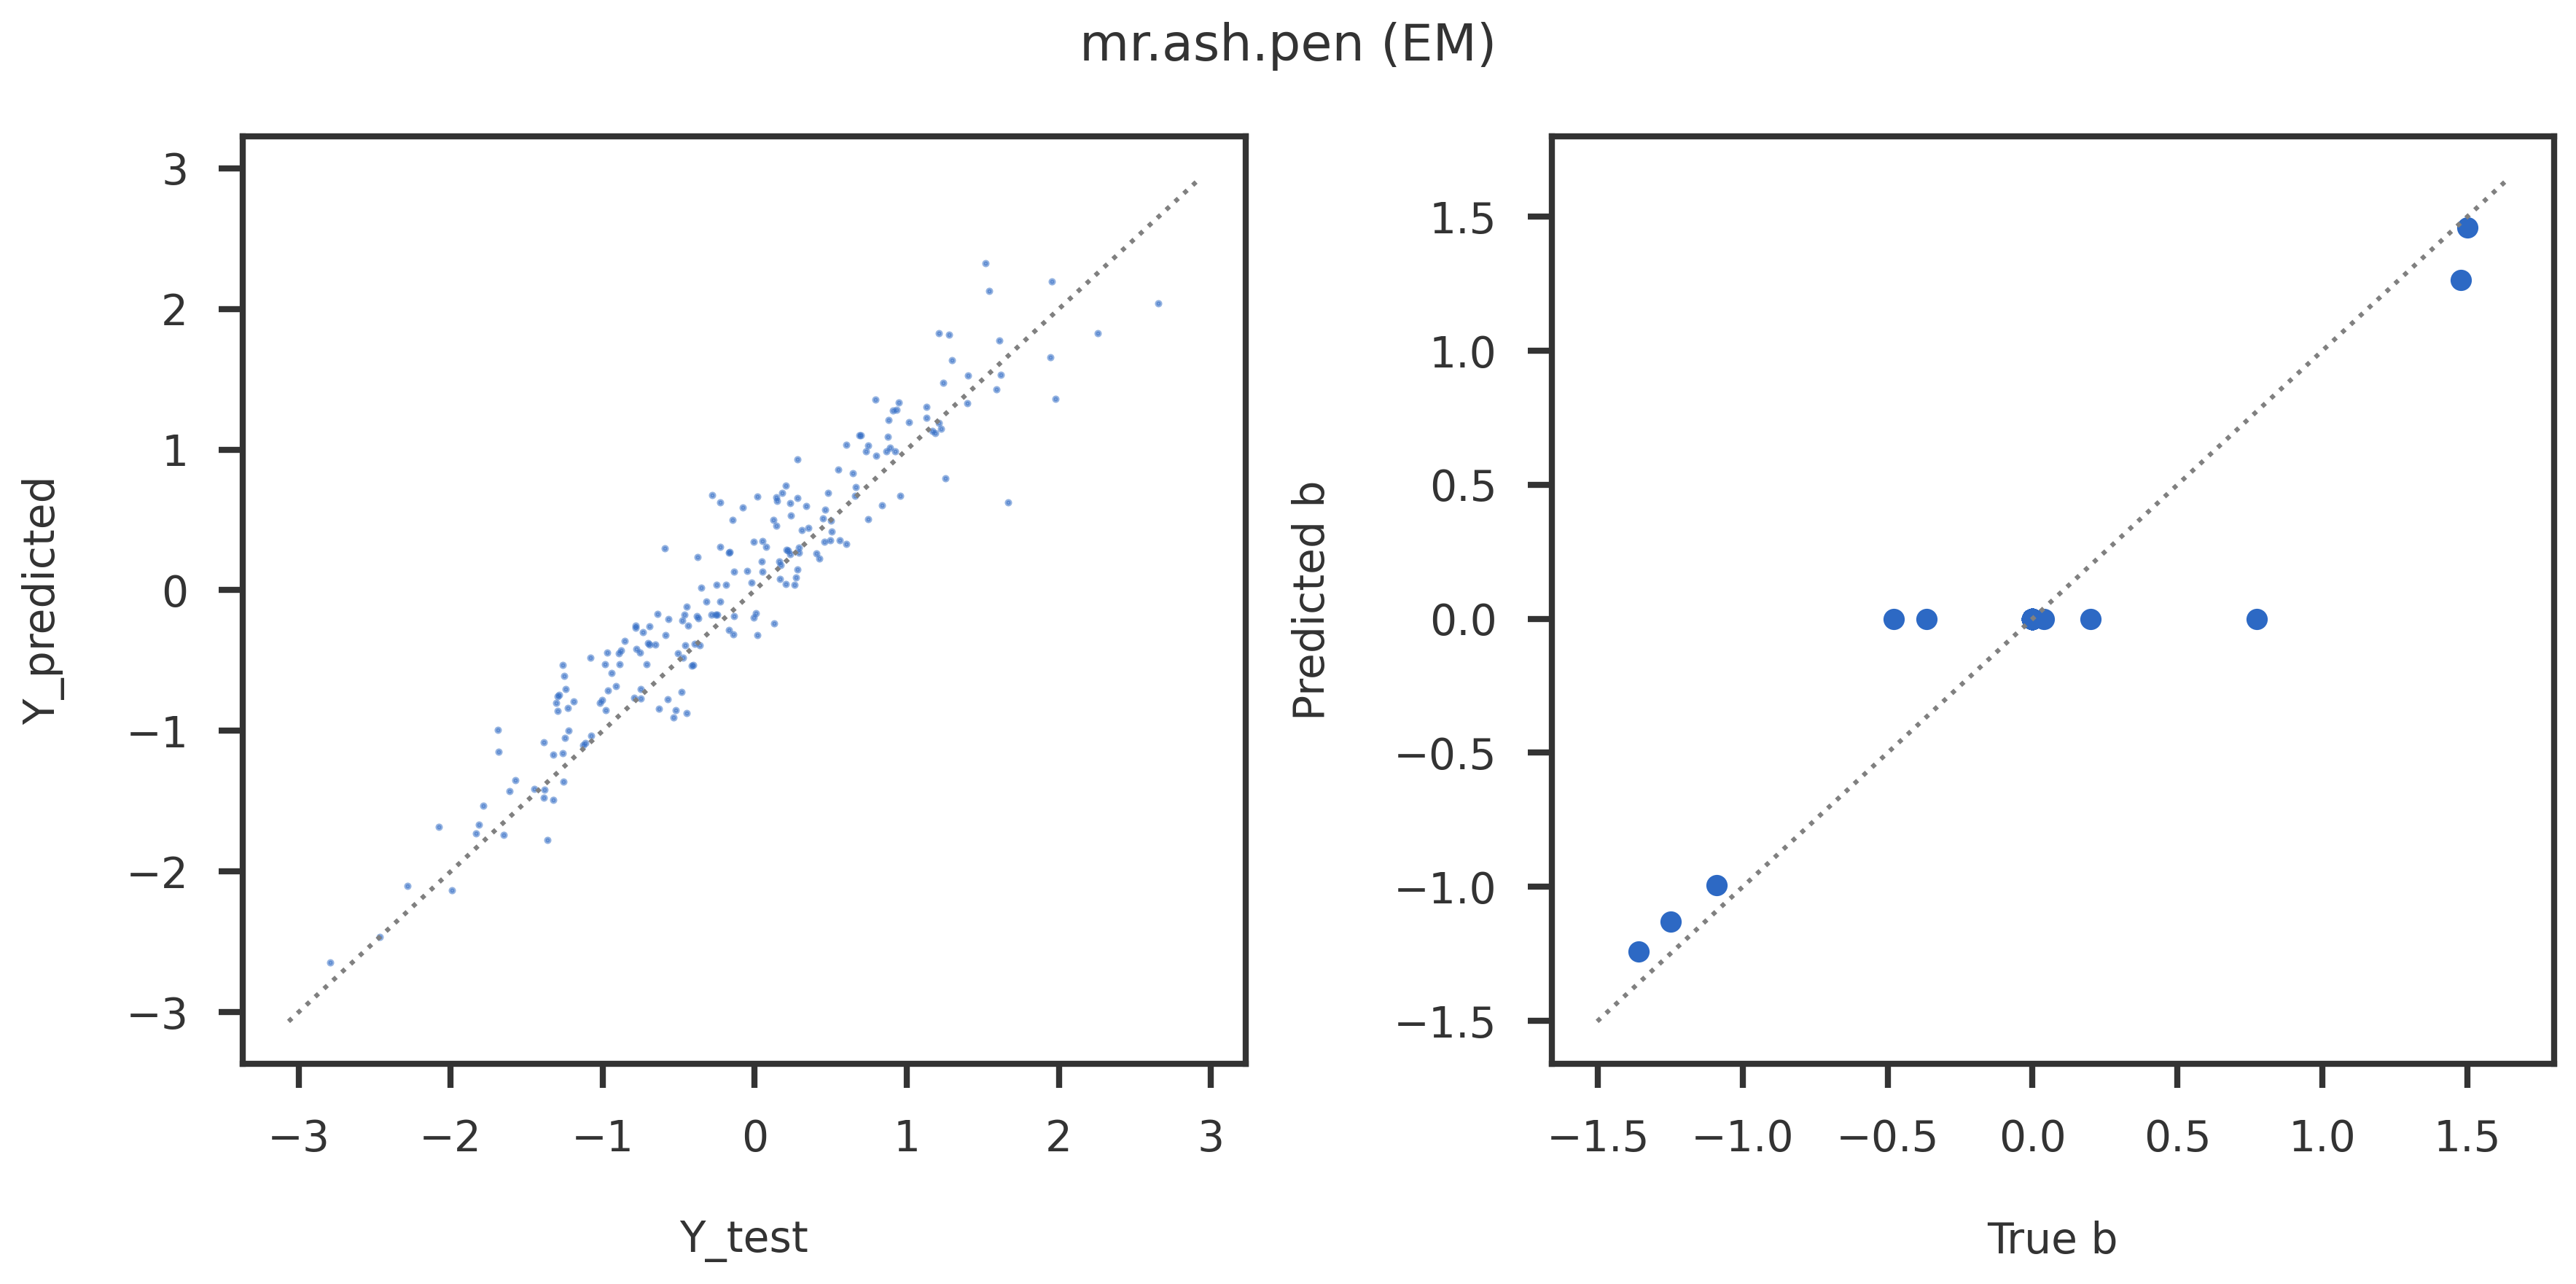

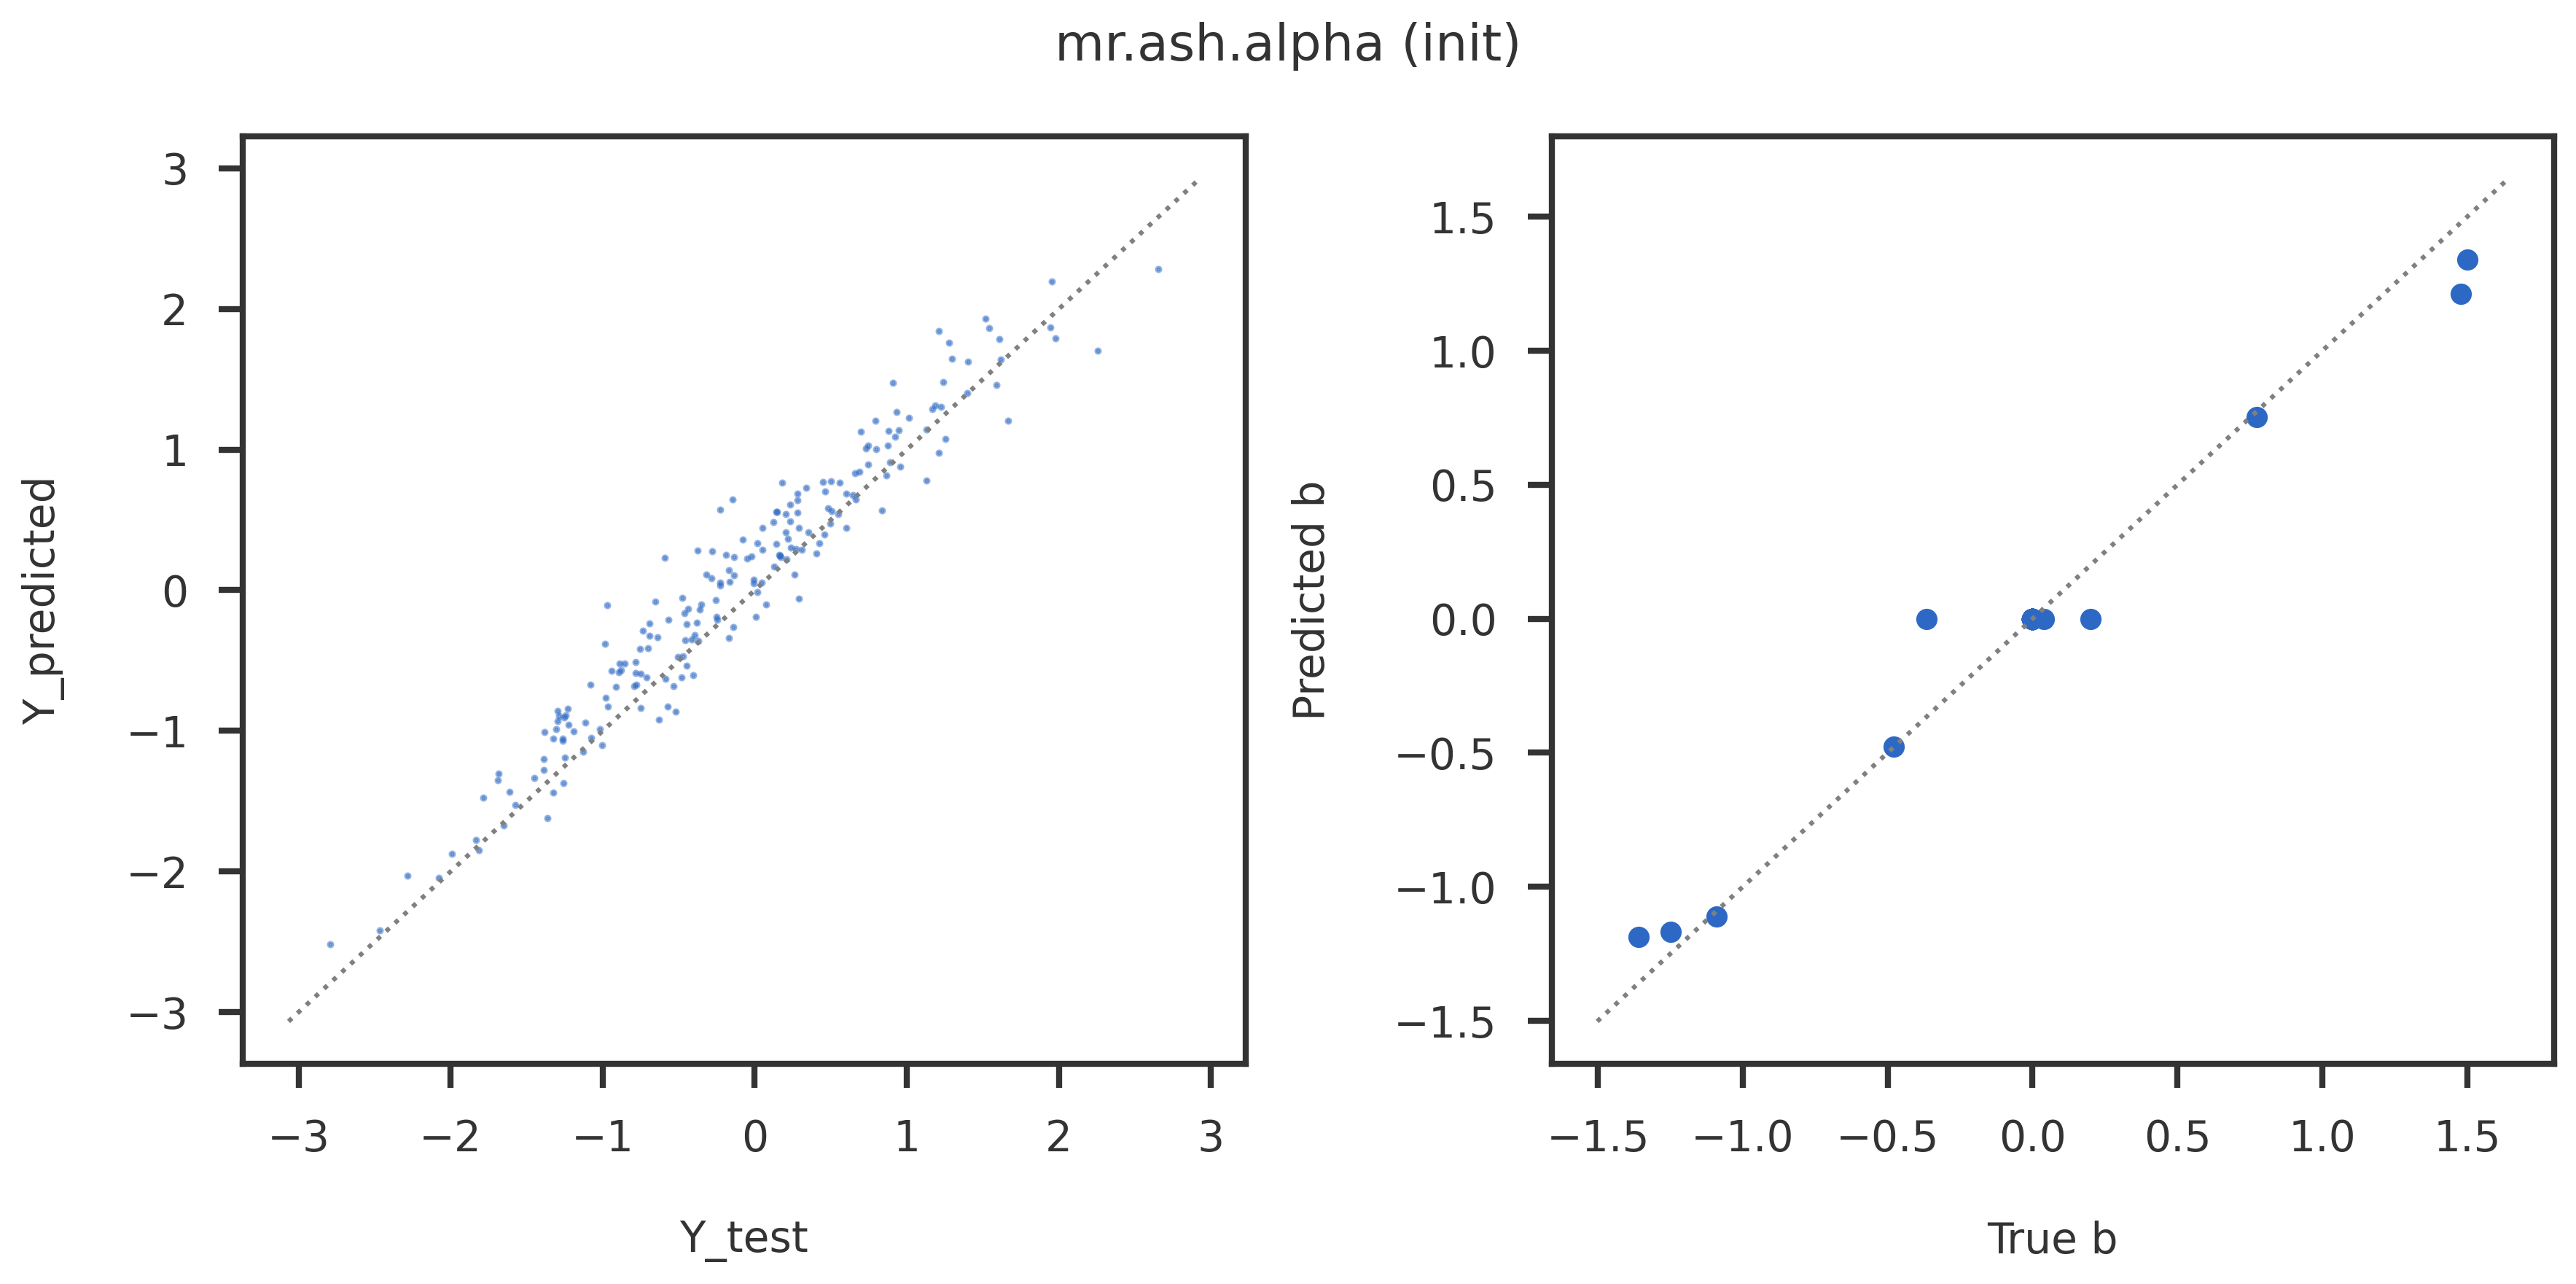

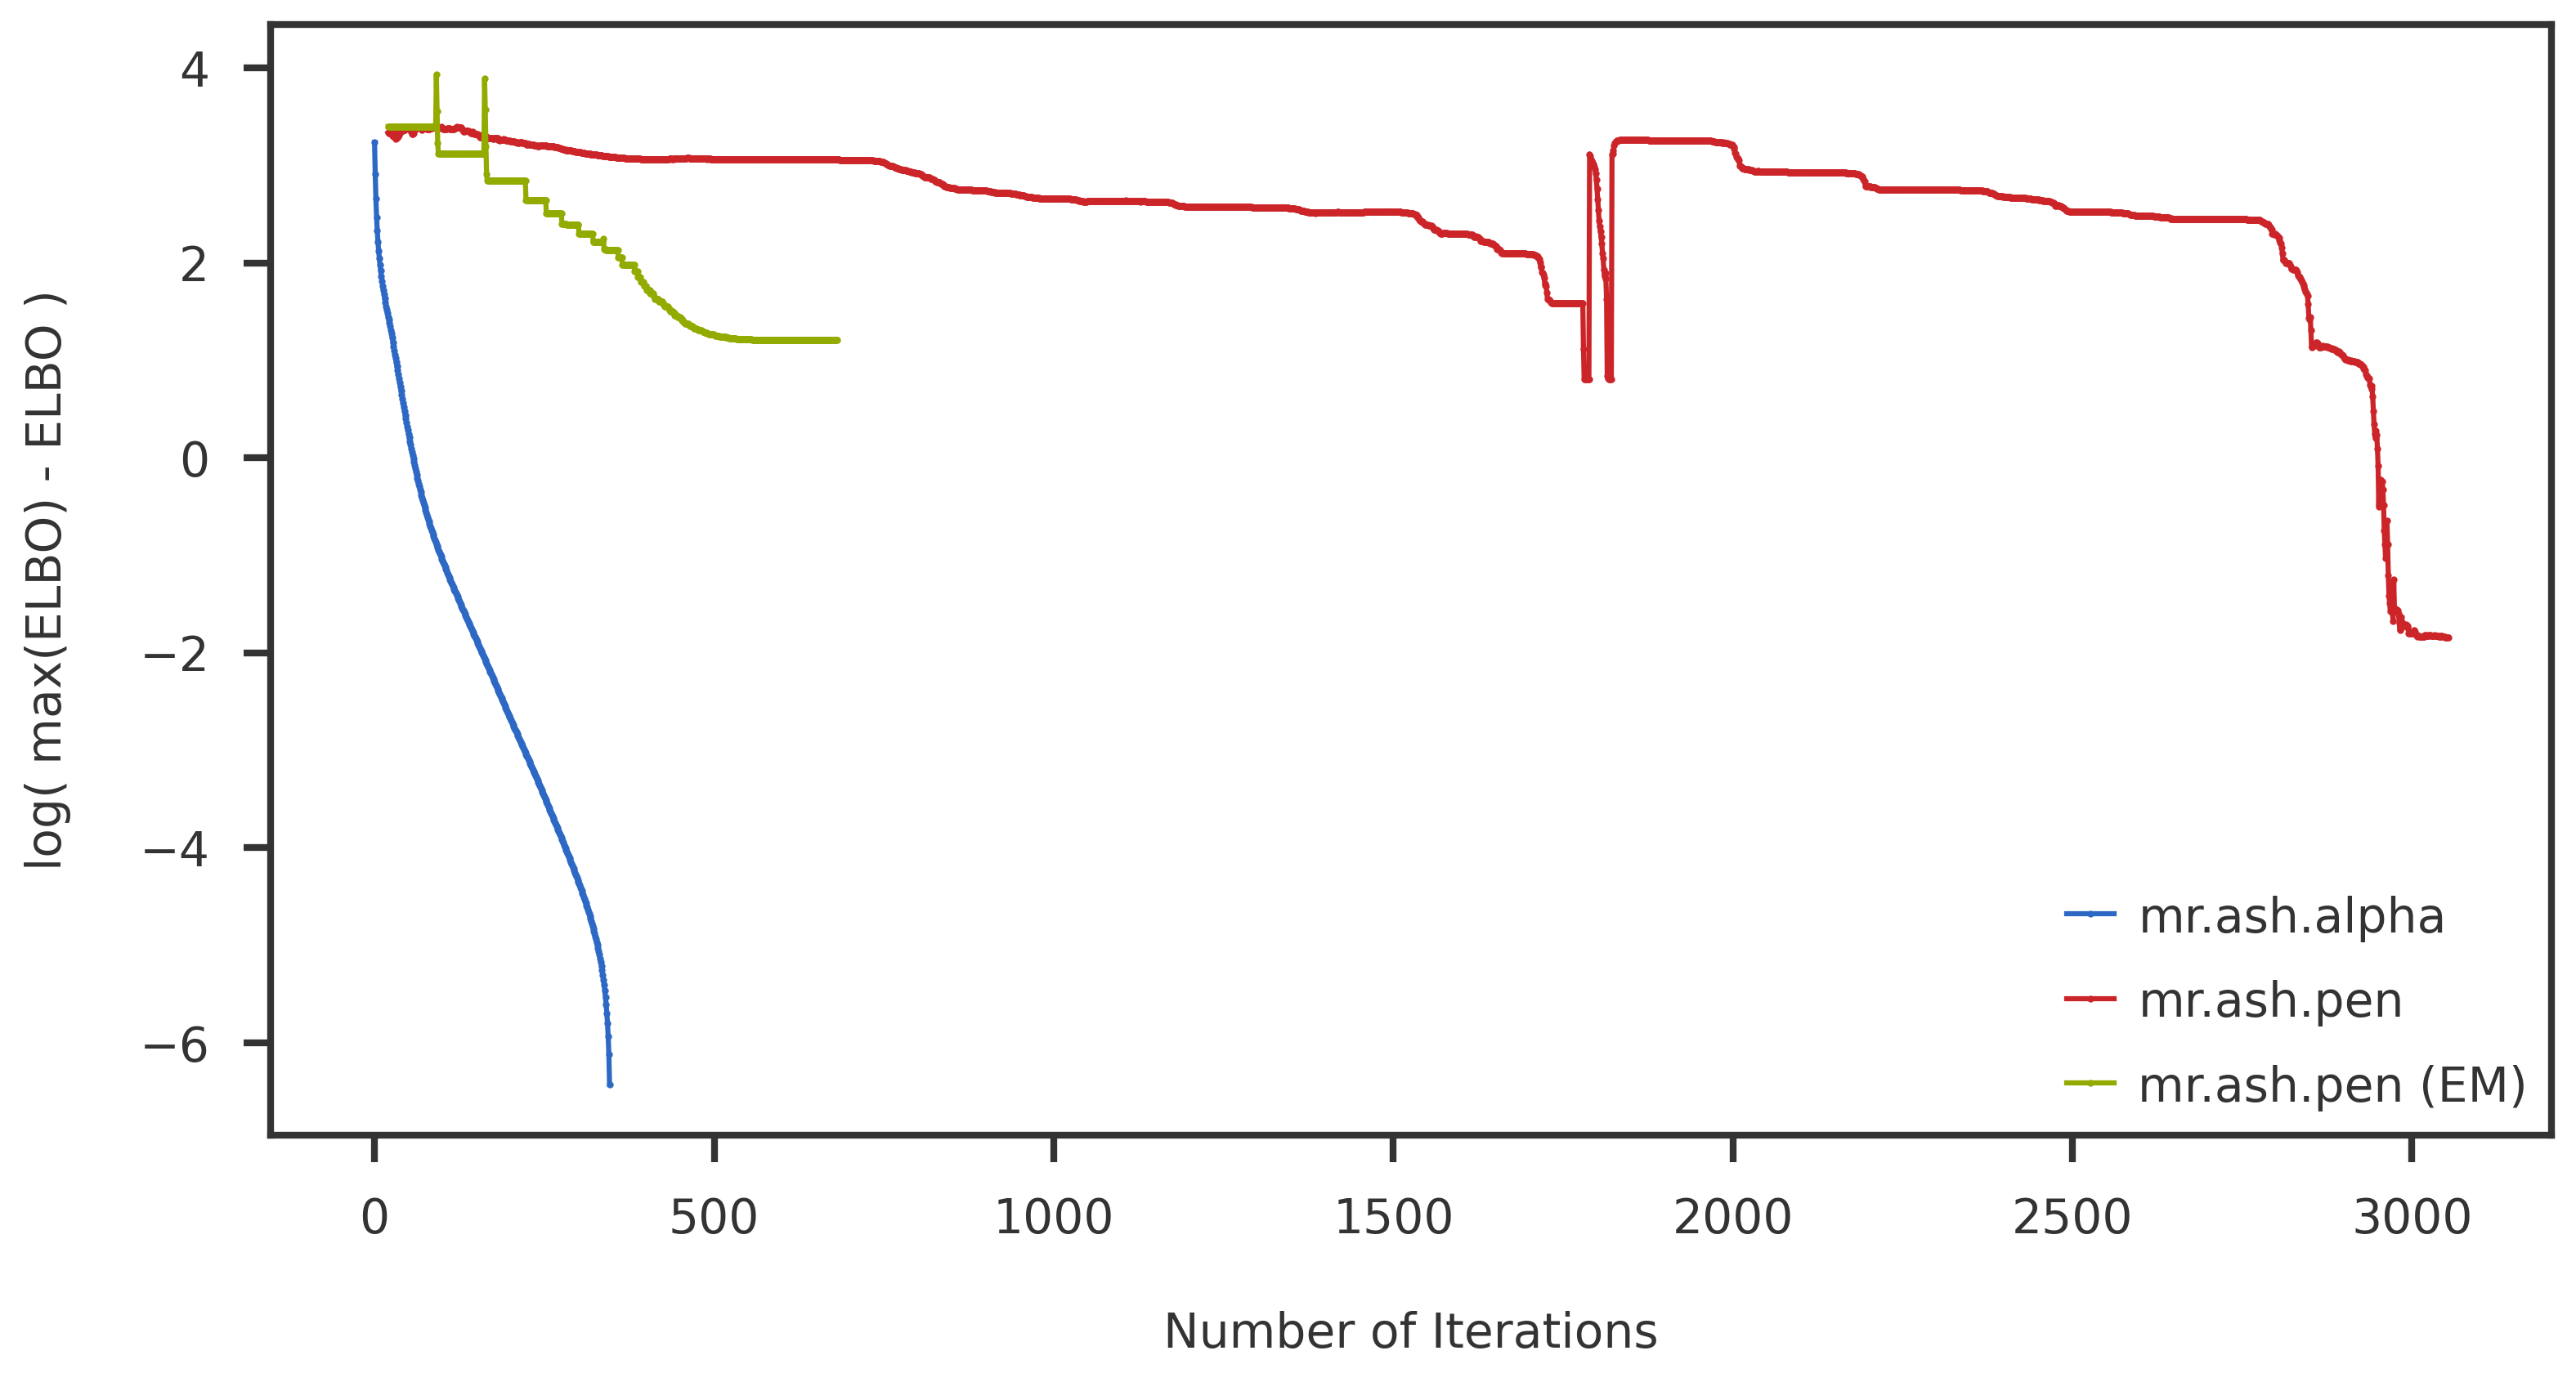

In [4]:
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     lasso_b, intercept = lasso_a0, title = 'Lasso')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue,
                     mrash_r.coef, intercept = mrash_r.intercept, title = 'mr.ash.alpha')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_lbfgs.plr3.coef, intercept = plr_lbfgs.plr3.intercept, title = 'mr.ash.pen')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_eb.coef, intercept = plr_eb.intercept, title = 'mr.ash.pen (EM)')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     mrash_r_init.coef, intercept = mrash_r_init.intercept, title = 'mr.ash.alpha (init)')

kinit   = [0, 20, 20, 0]
objs    = [mrash_r.obj_path, plr_lbfgs.elbo_path, plr_eb.elbo_path]
methods = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)"]
plot_convergence(objs, methods, kinit)

In [64]:
kinit   = [0, 0, 20]
objs    = [mrash_r.obj_path, plr_lbfgs.plr4.elbo_path, plr_eb.elbo_path]
methods = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)"]

fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(111)

objmin  = np.min([np.min(x) for x in objs])

for obj, method, iteq in zip(objs, methods, kinit):
    m_obj = obj[iteq:] - objmin
    m_obj = m_obj[m_obj > 0]
    ax1.plot(range(iteq, len(m_obj) + iteq), np.log10(m_obj), label = method, 
             marker = 'o', markersize = 1)
ax1.legend()

ax1.set_xlabel("Number of Iterations")
ax1.set_ylabel("log( max(ELBO) - ELBO )")

plt.show()

AttributeError: 'ResInfo' object has no attribute 'plr4'

In [60]:
np.log10(objs[0][:-1] - objmin)

array([ 3.23438396,  2.91350618,  2.65625542,  2.46894702,  2.32792044,
        2.21679348,  2.12558251,  2.04791371,  1.97950366,  1.91768653,
        1.86121924,  1.80955752,  1.76186184,  1.71705502,  1.67411721,
        1.6322894 ,  1.59165117,  1.55288924,  1.5160601 ,  1.48061918,
        1.44642767,  1.41353529,  1.38130076,  1.34820104,  1.31243441,
        1.27287036,  1.23000329,  1.18593999,  1.14266926,  1.10075984,
        1.05992873,  1.01967841,  0.97944293,  0.93876658,  0.89746988,
        0.85563078,  0.81345448,  0.77115661,  0.72890432,  0.68680584,
        0.64492473,  0.60329888,  0.56195448,  0.52091353,  0.48019706,
        0.43982609,  0.39982187,  0.36020562,  0.32099843,  0.28222098,
        0.24389338,  0.20603494,  0.16866404,  0.13179794,  0.09545263,
        0.05964268,  0.02438108, -0.01032083, -0.04445352, -0.07800933,
       -0.11098253, -0.14336938, -0.17516813, -0.20637902, -0.23700427,
       -0.26704799, -0.29651613, -0.32541637, -0.353758  , -0.38

In [51]:
objs     = [mrash_r, plr_lbfgs, plr_eb, mrash_r_init]
methods  = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)", "mr.ash.alpha (init)"]
df       = linreg_summary_df(strue, objs, methods)
df

,sigma2,ELBO,niter
True,0.043211,-,-
mr.ash.alpha,0.104509,122.031837,348
mr.ash.pen,0.102759,122.046215,2815
mr.ash.pen (EM),0.145124,138.236222,682
mr.ash.alpha (init),0.104509,122.031835,22


In [3]:
lasso_a0, lasso_b, _ = R_lasso.fit(X, y)
s2init = np.var(y - np.dot(X, lasso_b) - lasso_a0)

R[write to console]: Loading required package: Matrix



In [7]:
# lasso_a0, lasso_b, _ = R_lasso.fit(X, y)
s2init = np.var(y - np.dot(X, lasso_b) - lasso_a0)
# s2init = np.var(y - lasso_a0)
# wk_pen, sk_pen = initialize_ash_prior(k, scale = 3)

plr_debug = lbfgsfit(X, y, sk, wk, binit = lasso_b, s2init = s2init, calculate_elbo = False, maxiter = 10)
# plr_debug = PLR(method = 'L-BFGS-B', optimize_b = True, optimize_w = True, optimize_s = False, 
#                 is_prior_scaled = True,
#                 debug = False, display_progress = False, calculate_elbo = False, maxiter = 4000)

# # plr_debug.fit(X, y, sk, binit = mrash_r.coef, winit = wk, s2init = mrash_r.residual_var)
# plr_debug.fit(X, y, sk, binit = lasso_b, winit = wk, s2init = s2init)

# plr_debug2 = PLR(method = 'L-BFGS-B', optimize_b = False, optimize_w = False, optimize_s = True, 
#                  is_prior_scaled = True,
#                  debug = False, display_progress = False, calculate_elbo = False)

# # plr_debug.fit(X, y, sk, binit = mrash_r.coef, winit = wk, s2init = mrash_r.residual_var)
# plr_debug2.fit(X, y, sk, binit = plr_debug.theta, winit = plr_debug.prior, 
#                s2init = plr_debug.residual_var, unshrink_binit = False)

mr.ash.pen terminated at iteration 1977.
mr.ash.pen terminated at iteration 5.
mr.ash.pen terminated at iteration 1272.


In [9]:
print(get_elbos(X, y, plr_debug.plr1.coef, plr_debug.plr1.prior, sk, plr_debug.plr1.residual_var))

(240.91830682130694, 243.569504343916)


In [10]:
print(get_elbos(X, y, plr_debug.plr2.coef, plr_debug.plr2.prior, sk, plr_debug.plr2.residual_var))

(204.4010261930083, 207.0502287786097)


In [8]:
print(get_elbos(X, y, plr_debug.plr3.coef, plr_debug.plr3.prior, sk, plr_debug.plr3.residual_var))

(205.55886009947363, 208.21284926942792)


In [40]:
plr1 = PLR(method = 'L-BFGS-B', optimize_b = True, optimize_w = True, optimize_s = False, is_prior_scaled = True,
          debug = False, display_progress = False, calculate_elbo = False, maxiter = 4000)
plr1.fit(X, y - np.mean(y), sk, binit = lasso_b, winit = wk, s2init = s2init)

print(get_elbos(X, y, plr1.coef, plr1.prior, sk, plr1.residual_var))

mr.ash.pen terminated at iteration 1977.
(240.91830682130694, 243.569504343916)


In [41]:
plr2 = PLR(method = 'L-BFGS-B', optimize_b = False, optimize_w = False, optimize_s = True, is_prior_scaled = True,
          debug = False, display_progress = False, calculate_elbo = False, maxiter = 4000)
plr2.fit(X, y - np.mean(y), sk, binit = plr1.theta, winit = plr1.prior, s2init = plr1.residual_var, unshrink_binit = False)
print(get_elbos(X, y, plr2.coef, plr2.prior, sk, plr2.residual_var))

mr.ash.pen terminated at iteration 5.
(204.40106622360554, 208.8493313444082)


In [42]:
plr3 = PLR(method = 'L-BFGS-B', optimize_b = False, optimize_w = True, optimize_s = False, is_prior_scaled = True,
          debug = False, display_progress = False, calculate_elbo = False, maxiter = 4000)
plr3.fit(X, y - np.mean(y), sk, binit = plr2.theta, winit = plr2.prior, s2init = plr2.residual_var, unshrink_binit = False)
print(get_elbos(X, y, plr3.coef, plr3.prior, sk, plr3.residual_var))

mr.ash.pen terminated at iteration 34.
(123.92896689379396, 2017.1785797785913)


In [48]:
plr4 = PLR(method = 'L-BFGS-B', optimize_b = True, optimize_w = True, optimize_s = False, is_prior_scaled = True,
          debug = False, display_progress = False, calculate_elbo = False, maxiter = 4000)
plr4.fit(X, y - np.mean(y), sk, binit = plr3.theta, winit = plr3.prior, s2init = plr3.residual_var, unshrink_binit = False)
print(get_elbos(X, y, plr4.coef, plr4.prior, sk, plr4.residual_var))

mr.ash.pen terminated at iteration 1469.
(122.05184290523874, 124.70100968454528)


In [22]:
plr3.coef[btrue!=0]

array([ 1.21092792e+00, -1.17363999e+00, -1.15765218e+00, -1.09383142e+00,
        1.00212001e-06,  2.96157786e-06, -3.47825898e-06, -4.66670404e-01,
        1.34071918e+00,  7.59254792e-01])

In [23]:
plr4.coef[btrue!=0]

array([ 1.21113732e+00, -1.18815559e+00, -1.16834560e+00, -1.10967553e+00,
        8.41075910e-07,  2.74822120e-06, -3.25224049e-06, -4.78901158e-01,
        1.33934929e+00,  7.53643883e-01])

In [44]:
plr3.residual_var

0.10249257192858606

In [45]:
plr4.residual_var

0.10249013828372955

In [ ]:
plr3.

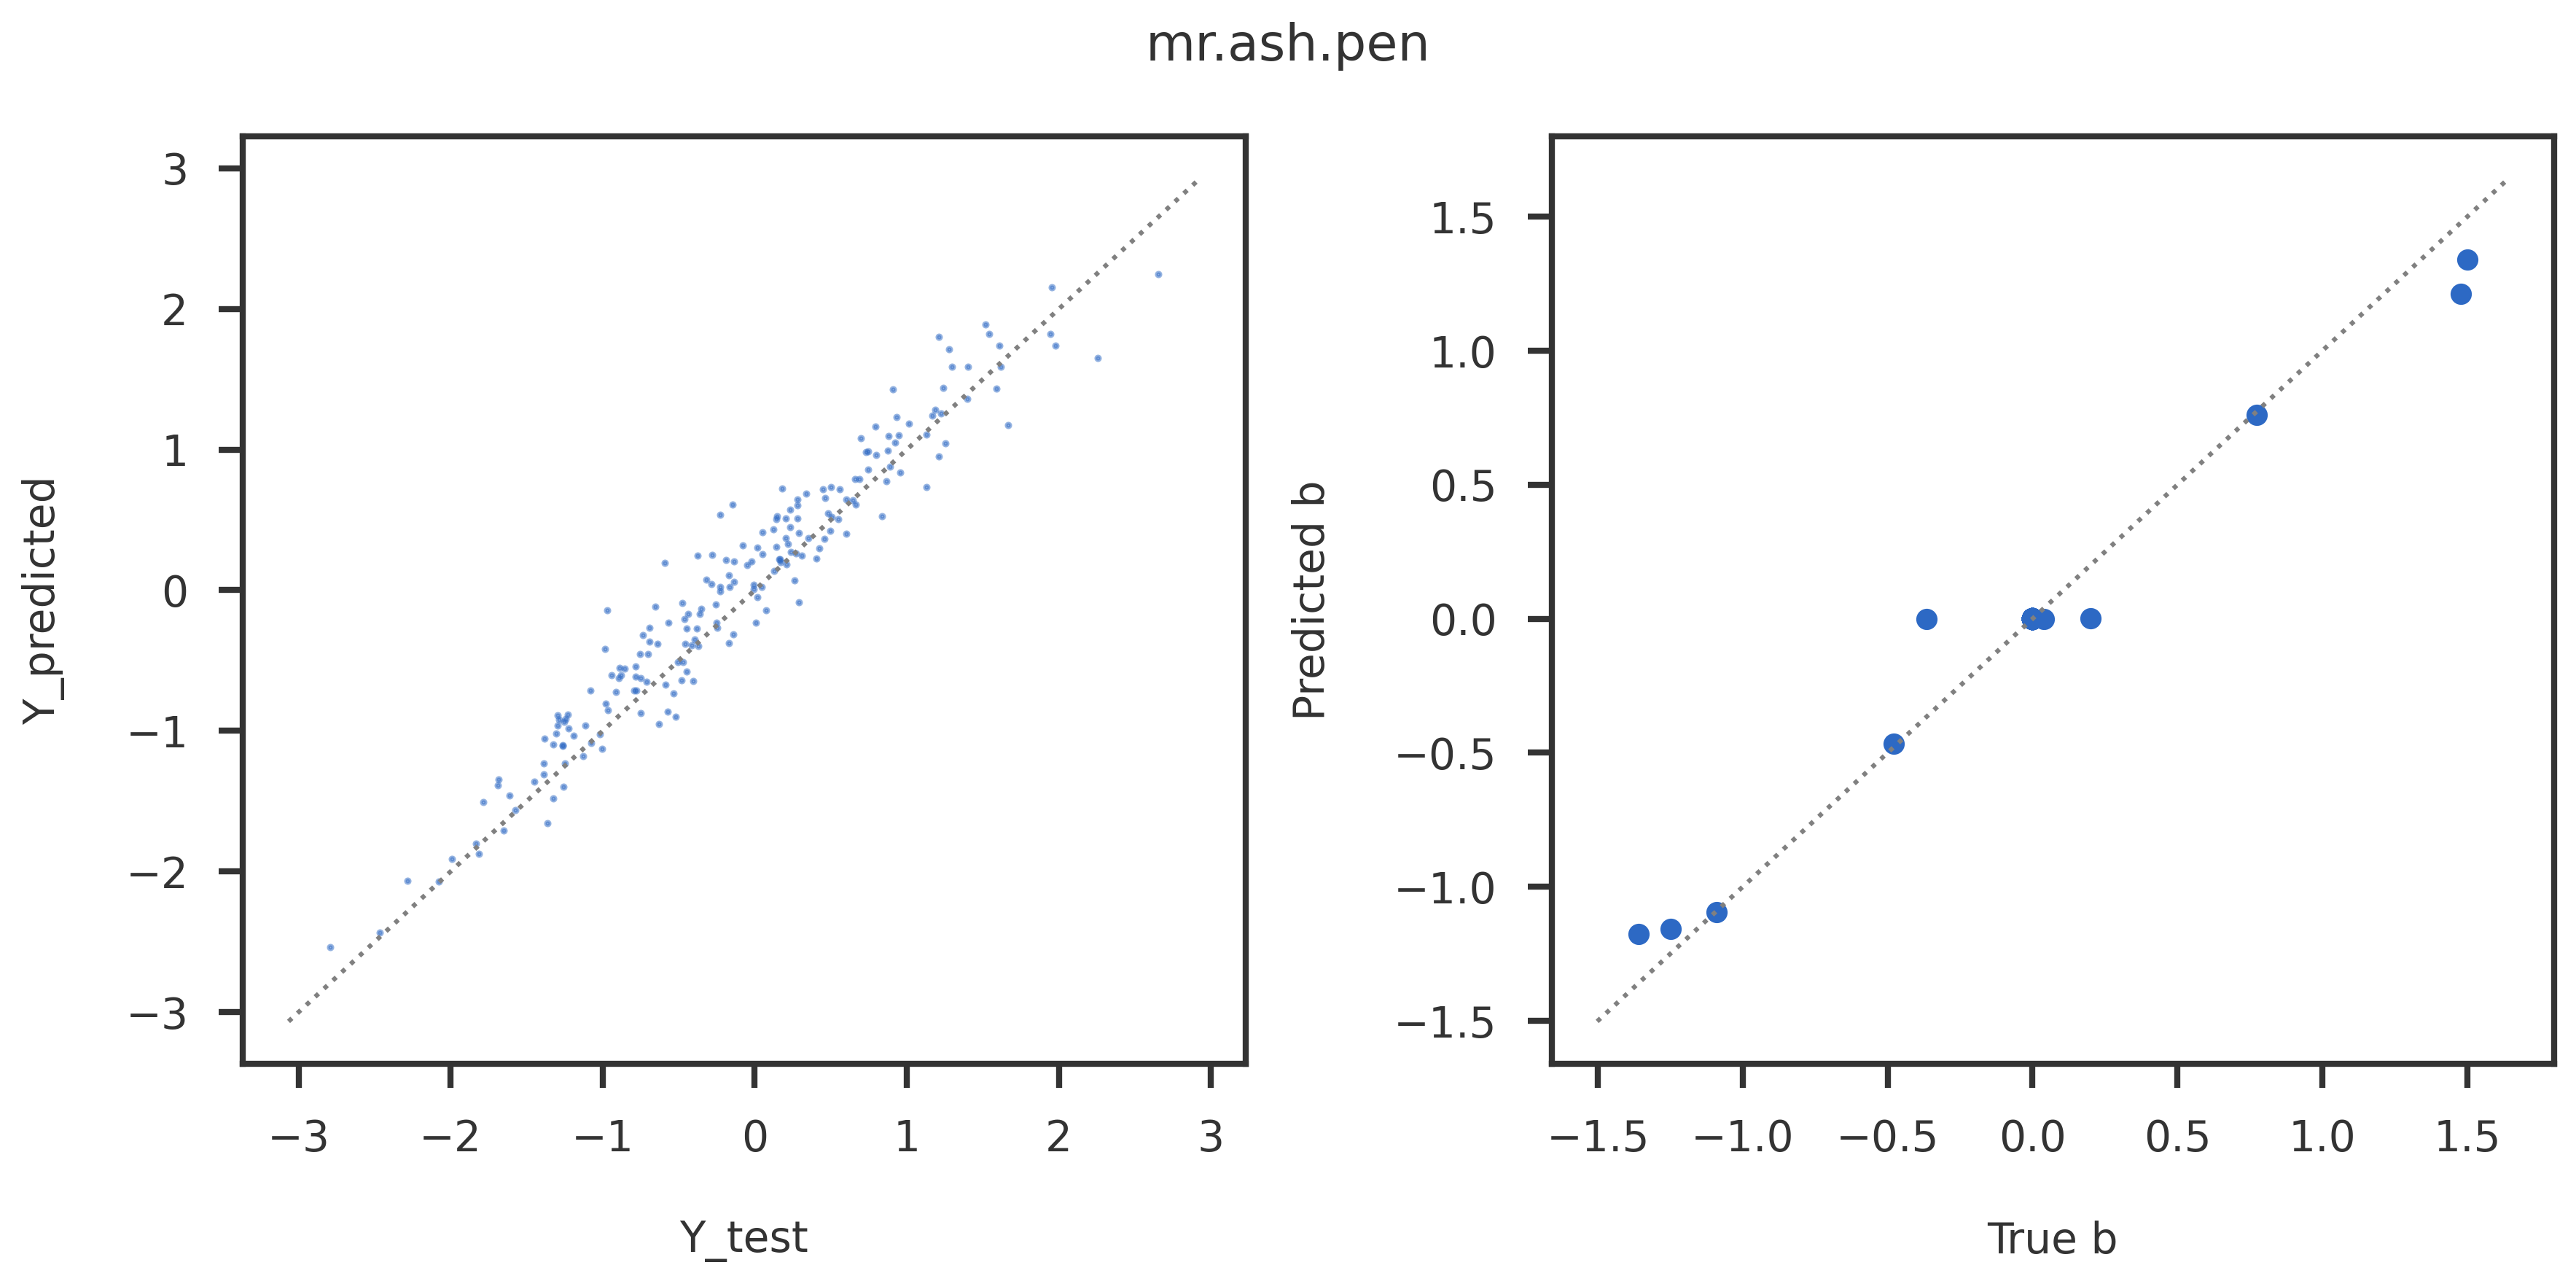

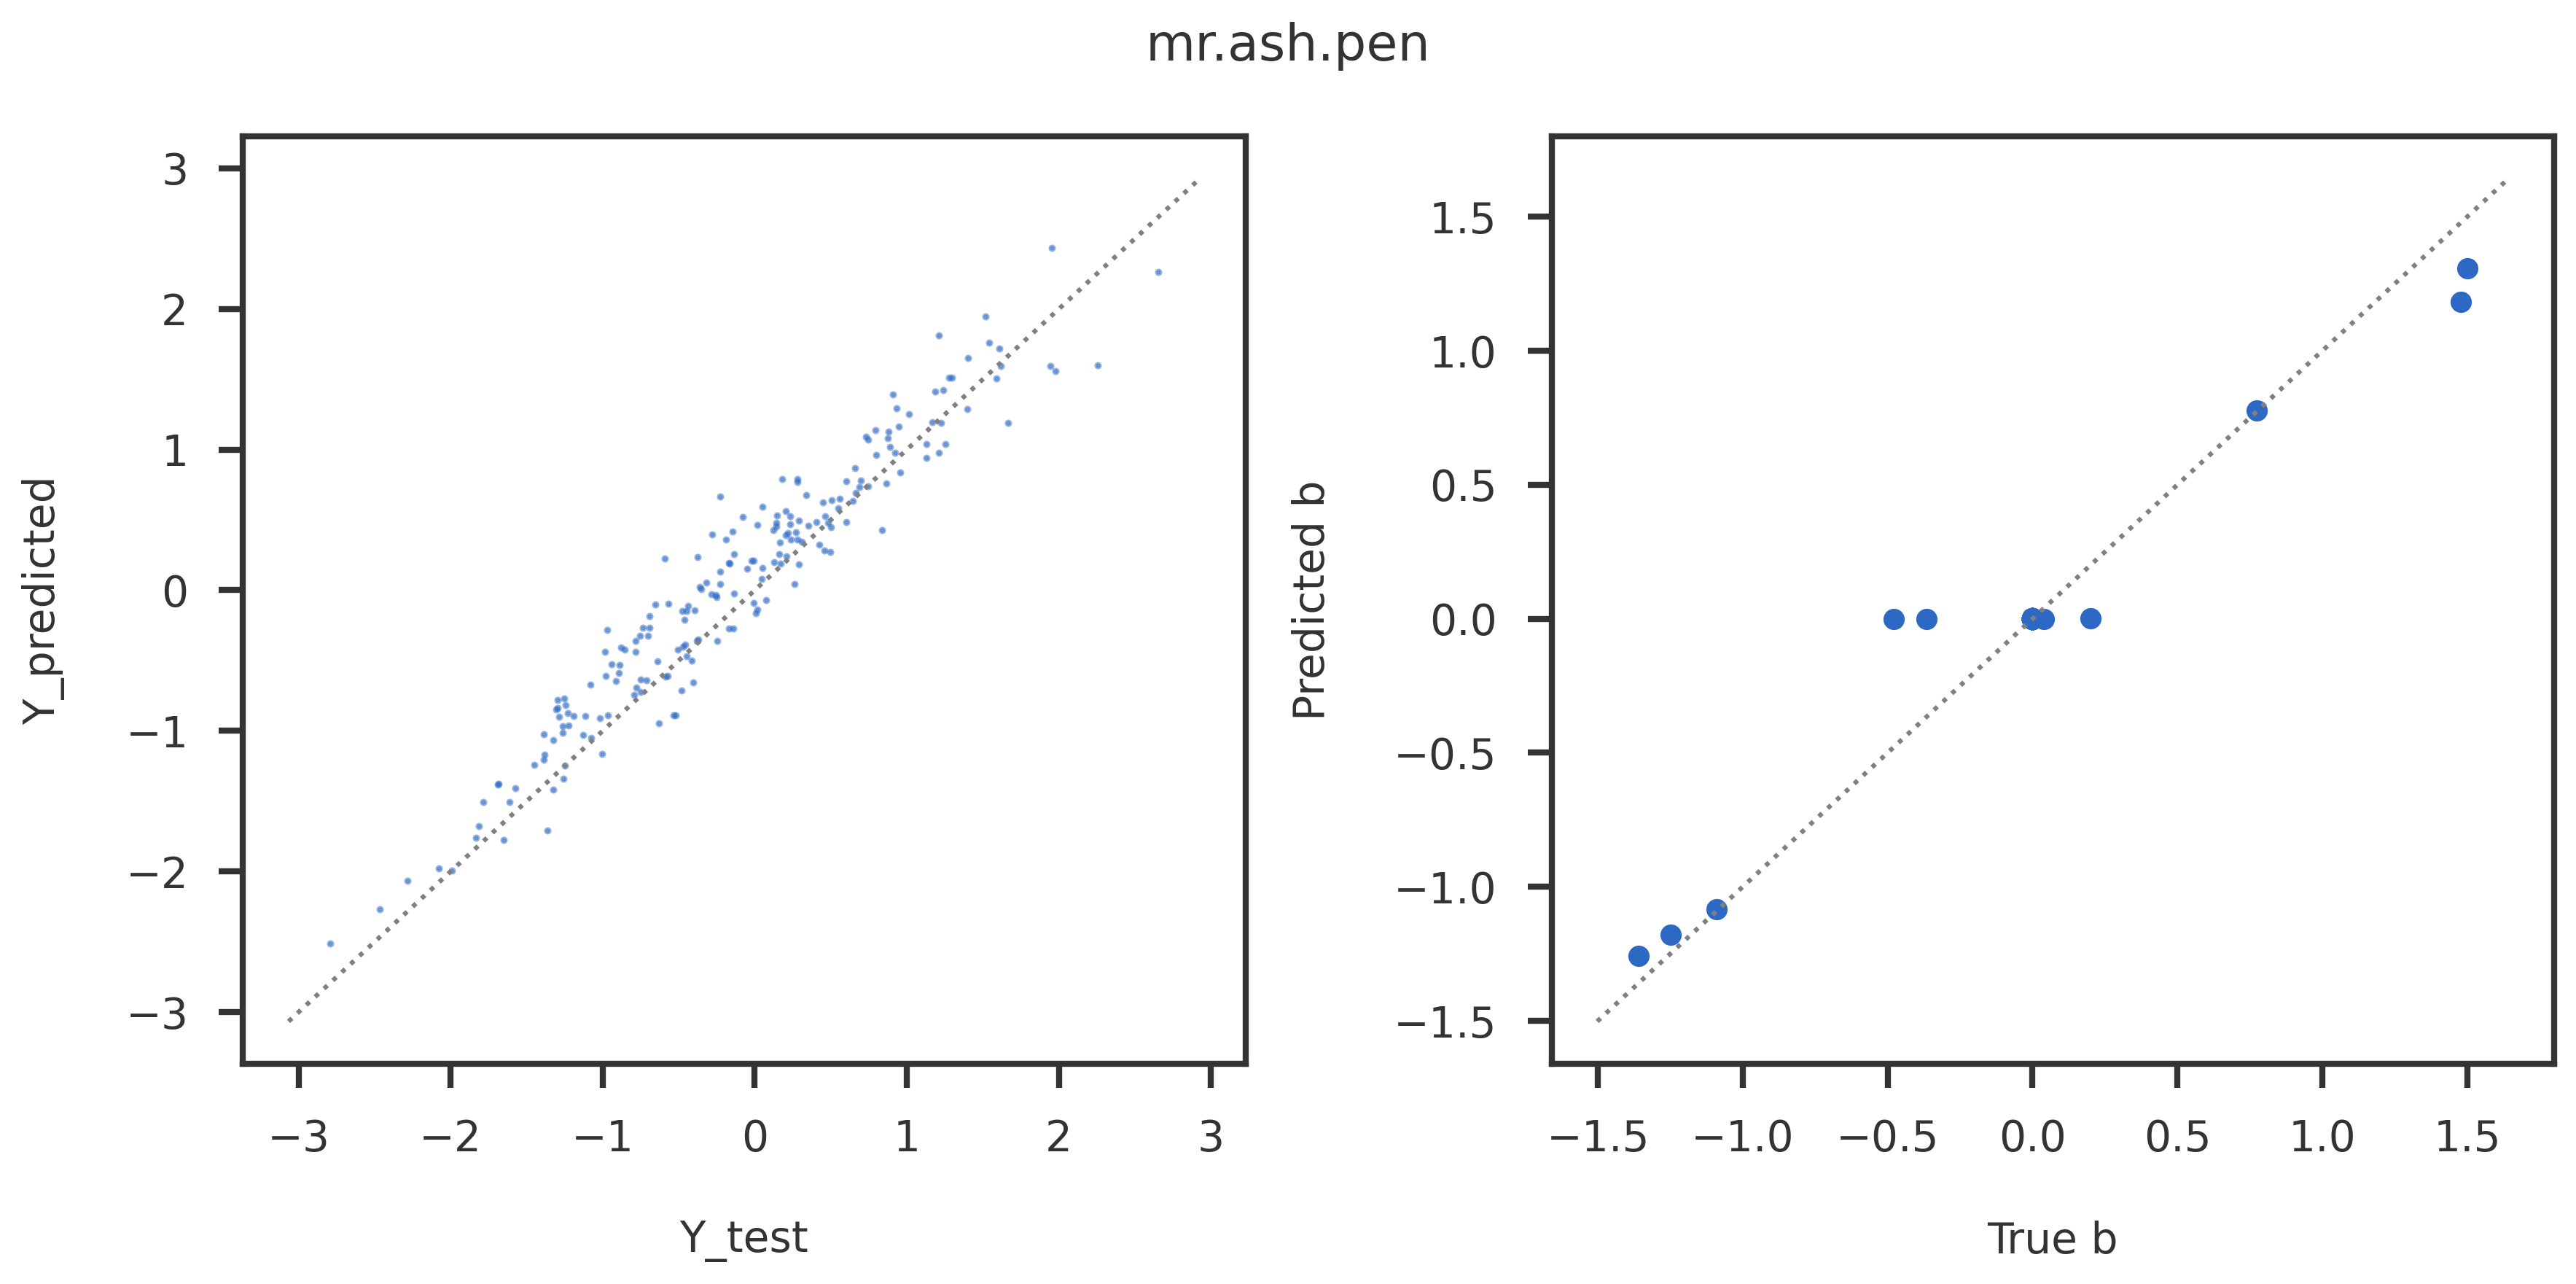

In [47]:
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr4.coef, intercept = plr4.intercept, title = 'mr.ash.pen')

plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_debug.coef, intercept = plr_debug.intercept, title = 'mr.ash.pen')

In [32]:
plr2.residual_var

0.10066679326998264

In [31]:
plr3.residual_var

8.285751759811854

(835.7699091959042, 1469.9189902872)

ELBO from step 1
147.65992363328968
ELBO from step 2
134.30455402505416
0.10244859601231811


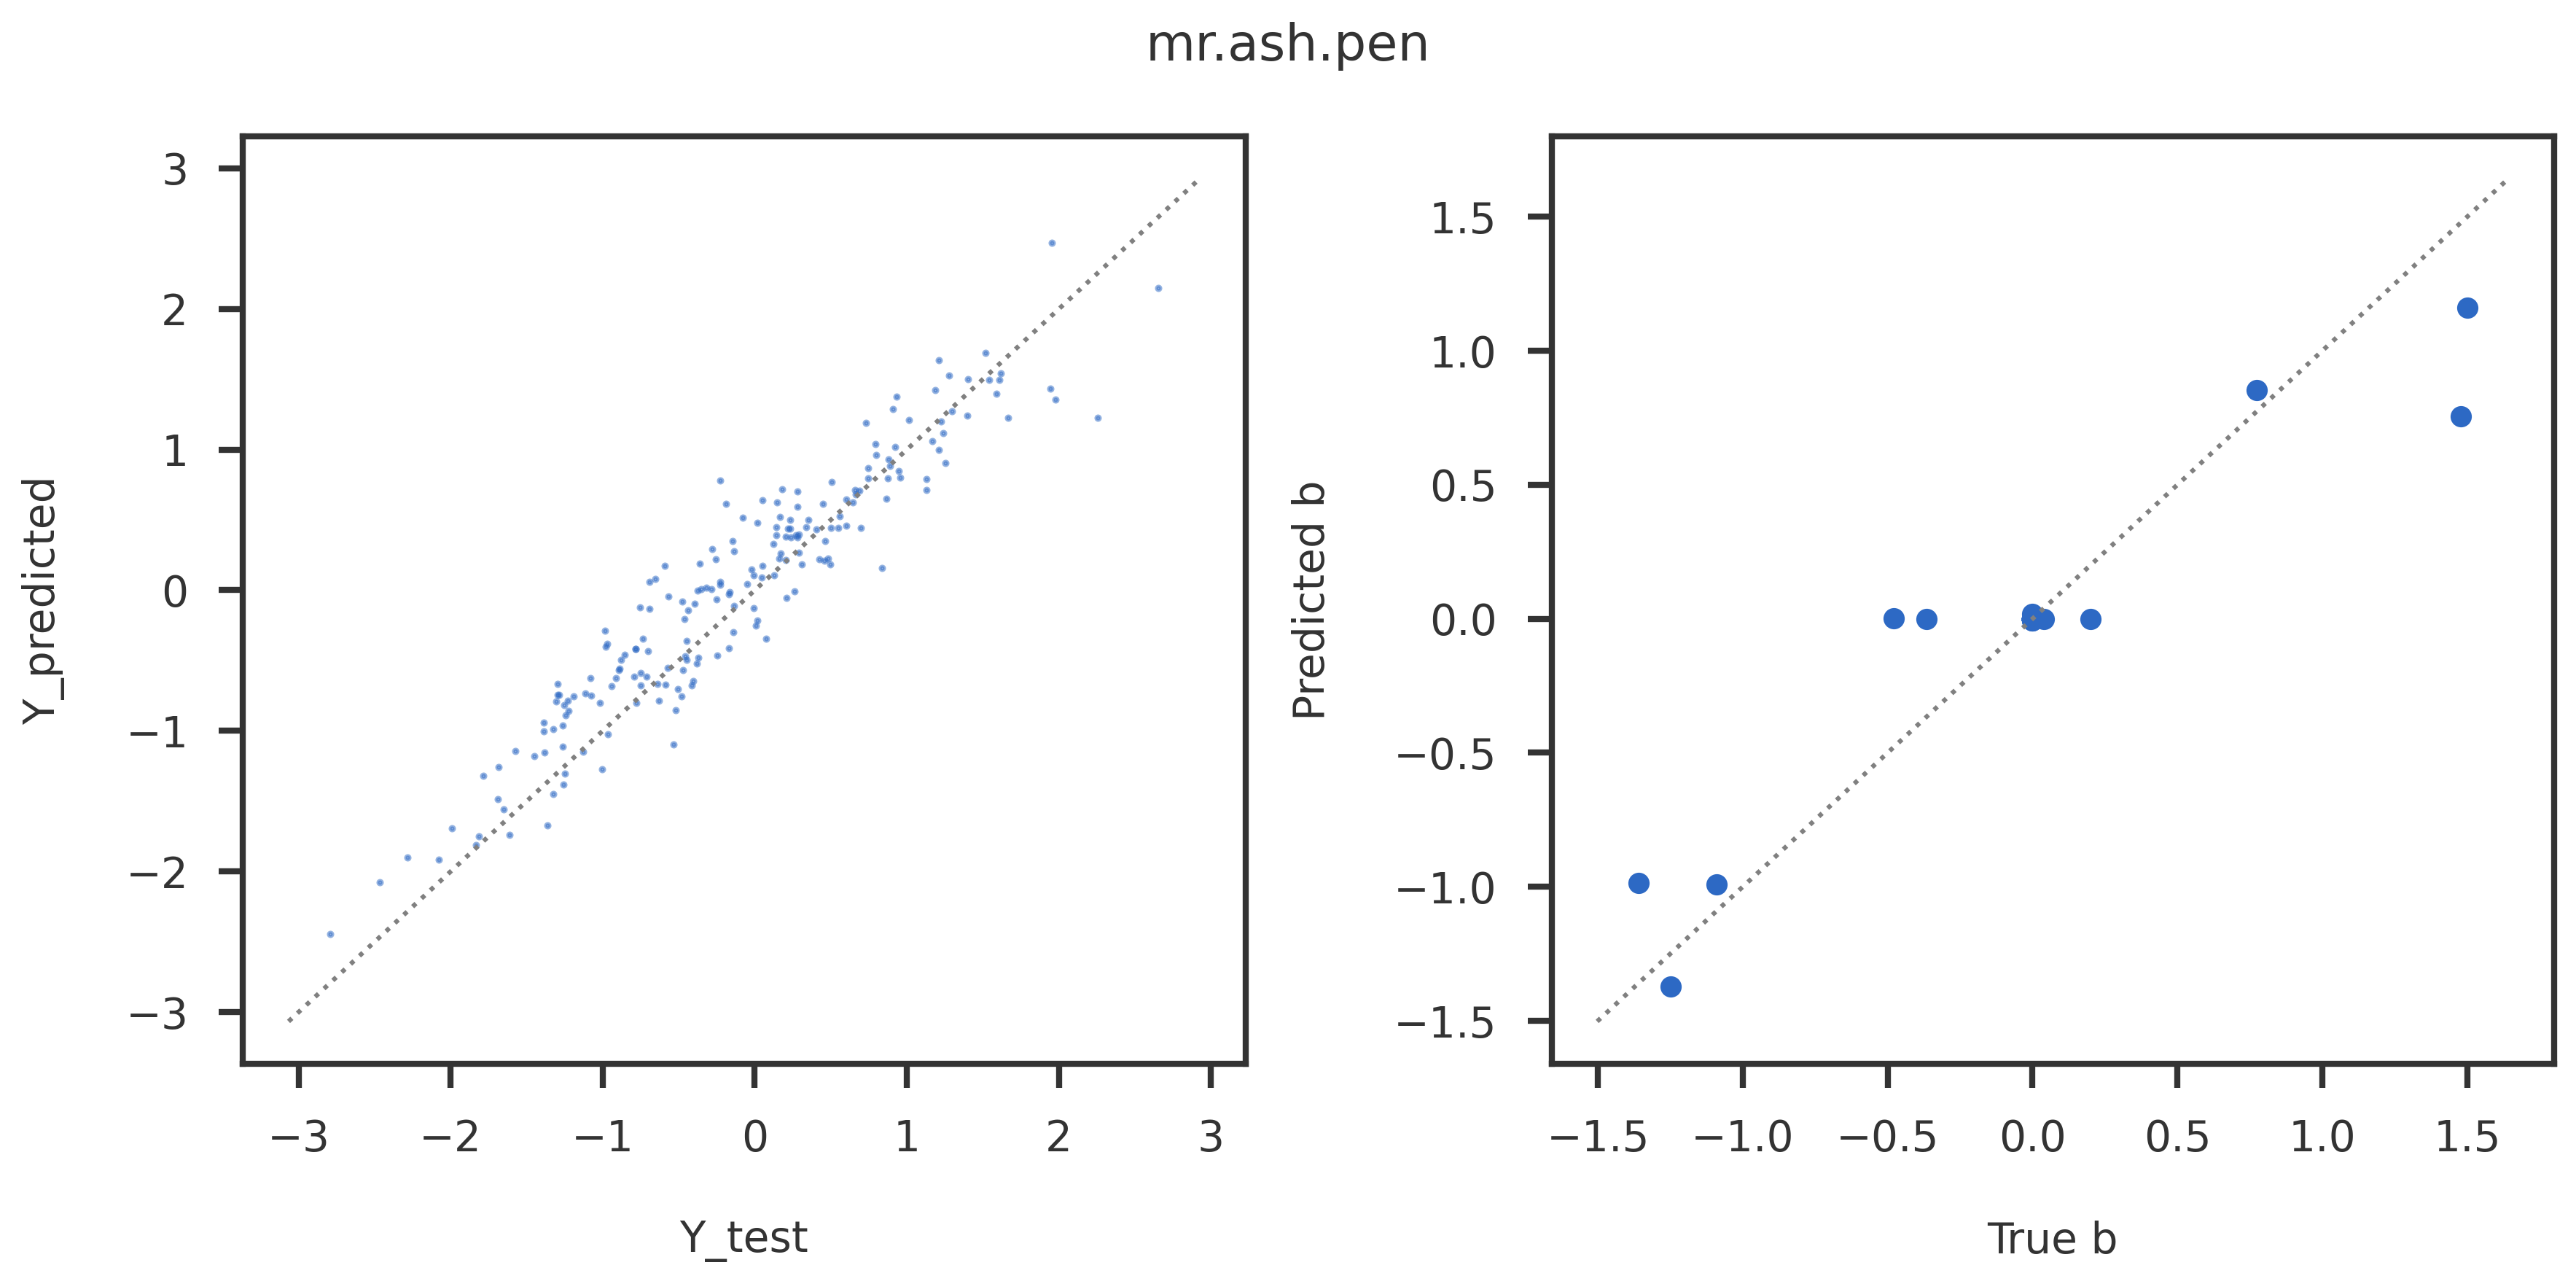

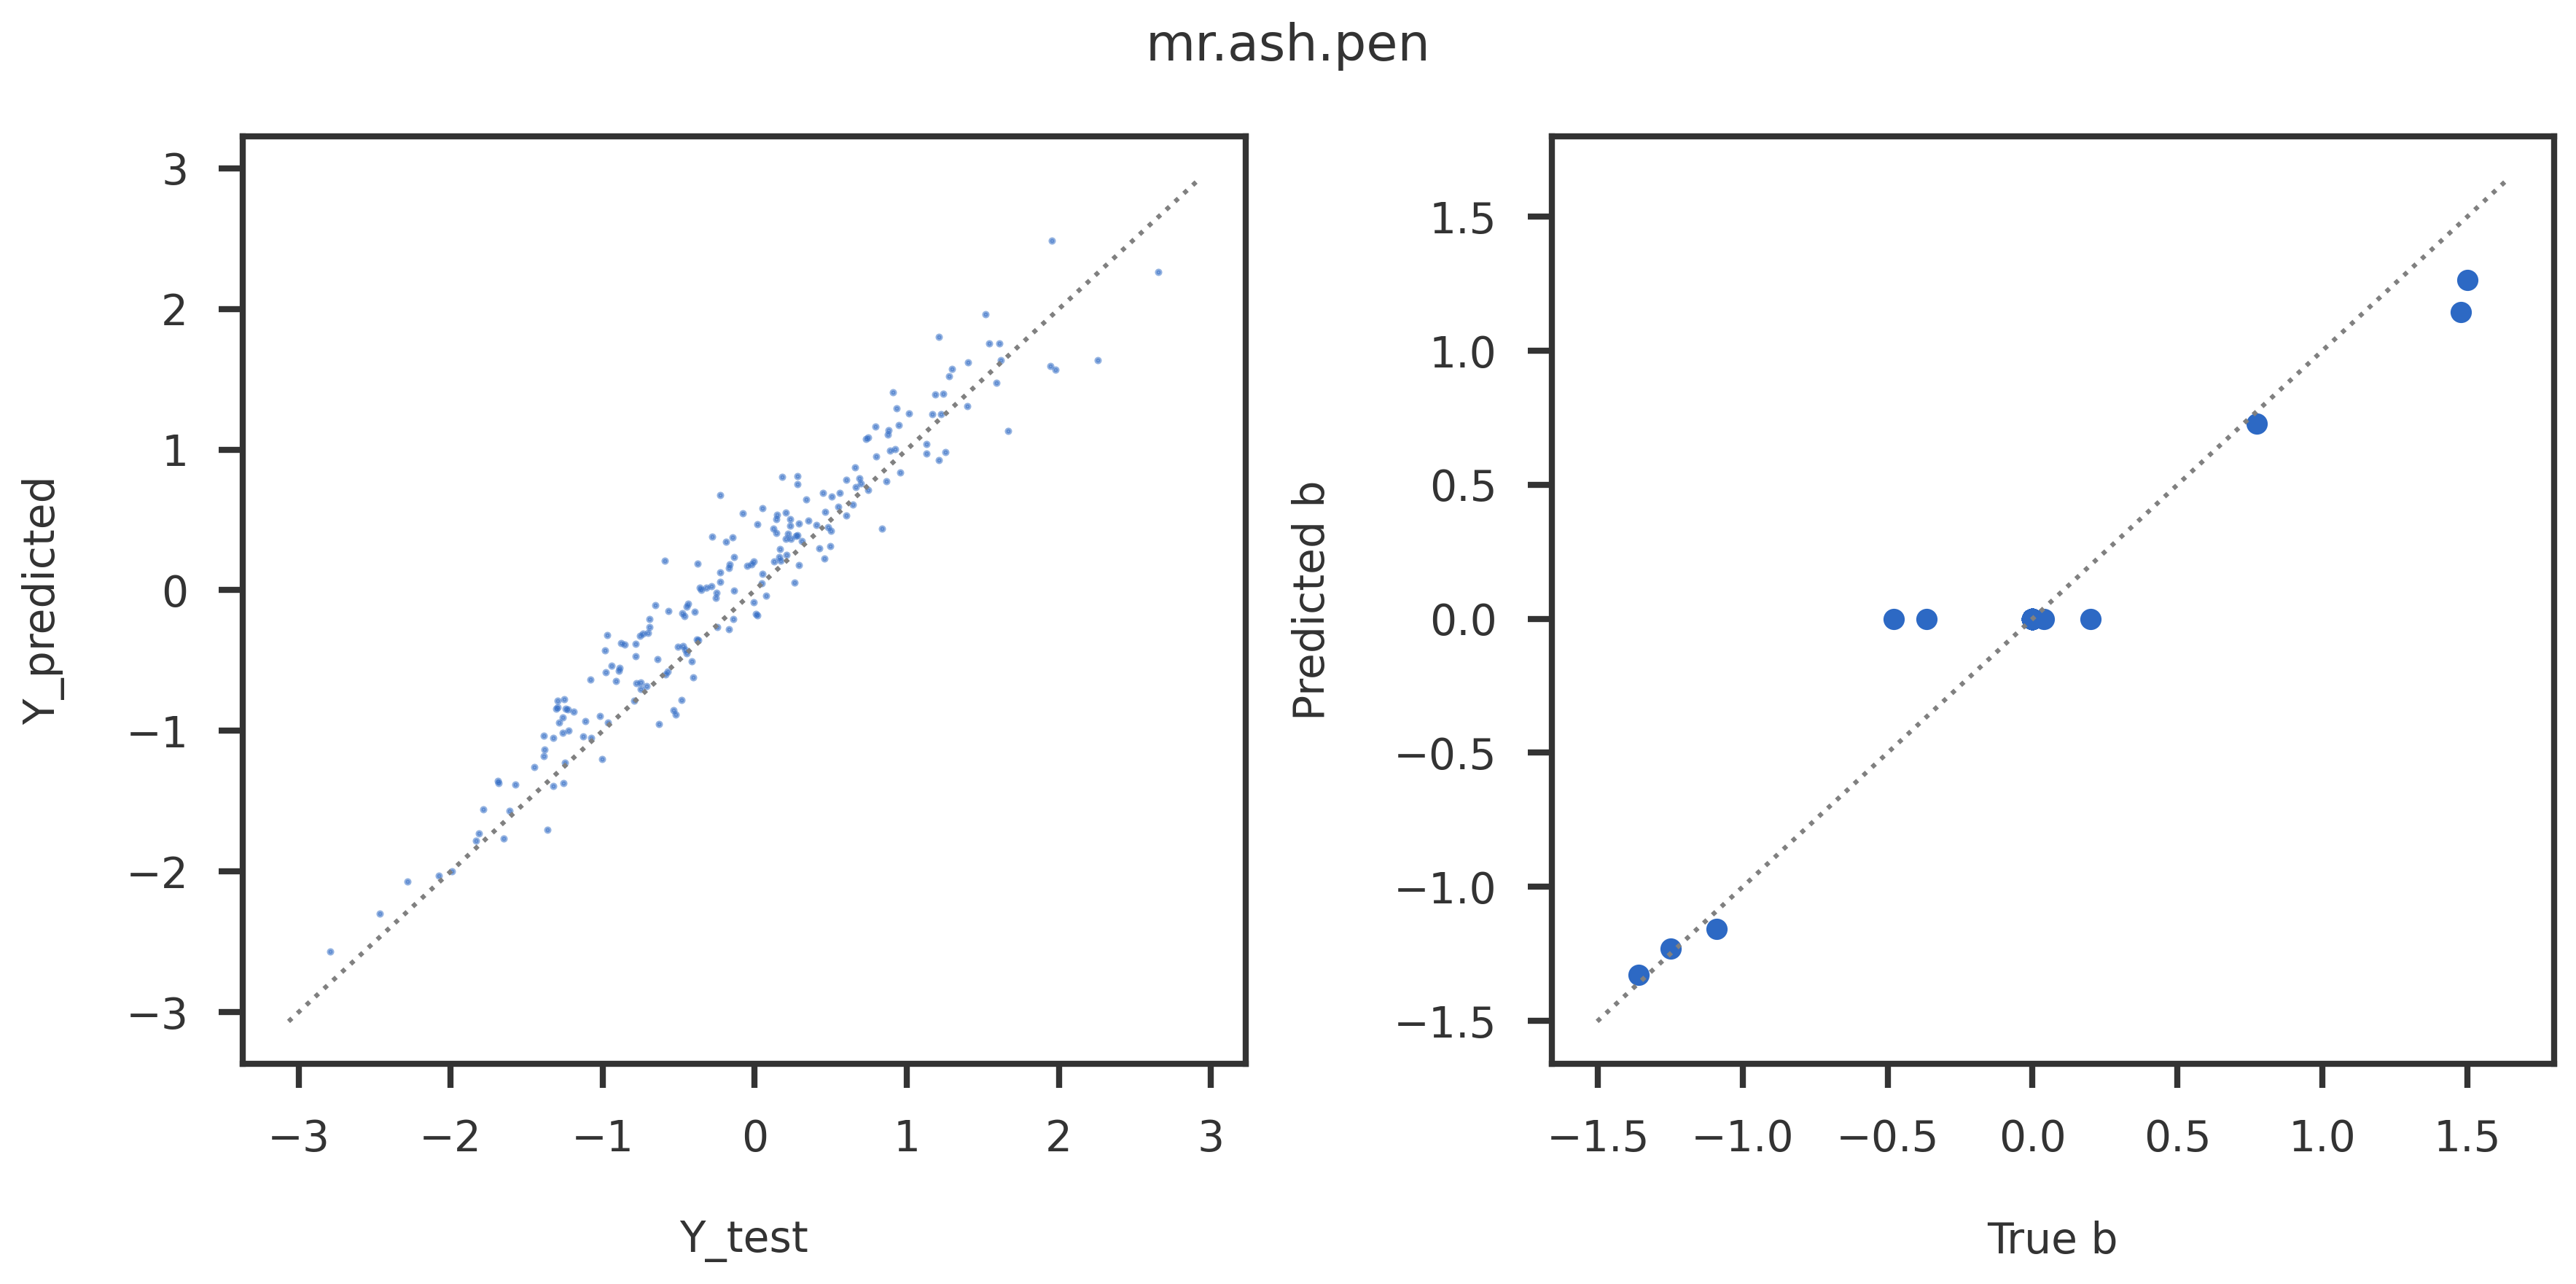

In [5]:
from mrashpen.inference import coordinate_descent_step as cd_step
print("ELBO from step 1")
print(cd_step.elbo(X, y, sk, plr_debug.plr1.coef, plr_debug.plr1.prior, plr_debug.plr1.residual_var))
print ("ELBO from step 2")
print(cd_step.elbo(X, y, sk, plr_debug.plr2.coef, plr_debug.plr2.prior, plr_debug.plr2.residual_var))
print(plr_debug.plr1.residual_var)

plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_debug.plr1.coef, intercept = plr_debug.plr1.intercept, title = 'mr.ash.pen')

plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_debug.coef, intercept = plr_debug.intercept, title = 'mr.ash.pen')

In [6]:
plr_debug.outer_elbo_path

[128.19824525082112, 134.30455402505416]

In [42]:
plr1 = PLR(method = 'L-BFGS-B', optimize_b = True, optimize_w = True, optimize_s = False, is_prior_scaled = True,
           debug = debug, display_progress = display_progress, calculate_elbo = calculate_elbo, maxiter = maxiter)
plr1.fit(X, y, sk, binit = binit, winit = wk, s2init = s2init)

plr2 = PLR(method = 'L-BFGS-B', optimize_b = True, optimize_w = True, optimize_s = True, is_prior_scaled = True,
           debug = debug, display_progress = display_progress, calculate_elbo = calculate_elbo, maxiter = maxiter)
plr2.fit(X, y, sk, binit = plr1.theta, winit = plr1.prior, s2init = plr1.residual_var, unshrink_binit = False)

0.04590050021652674

In [45]:
plr_debug2.fitobj

      fun: -5176.284899826815
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([5.63884132e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 11
      nit: 6
     njev: 11
   status: 0
  success: True
        x: array([0.1045096])

In [49]:
plr_debug.b_to_theta(lasso_b)

array([ 0.00064392, -0.00404183,  0.00182855, ..., -0.00718283,
       -0.00252085, -0.00018435])

In [ ]:
plr_debug.b_to_theta()

mr.ash.pen terminated at iteration 1335.
205.51887290749258
0.11276912884302455


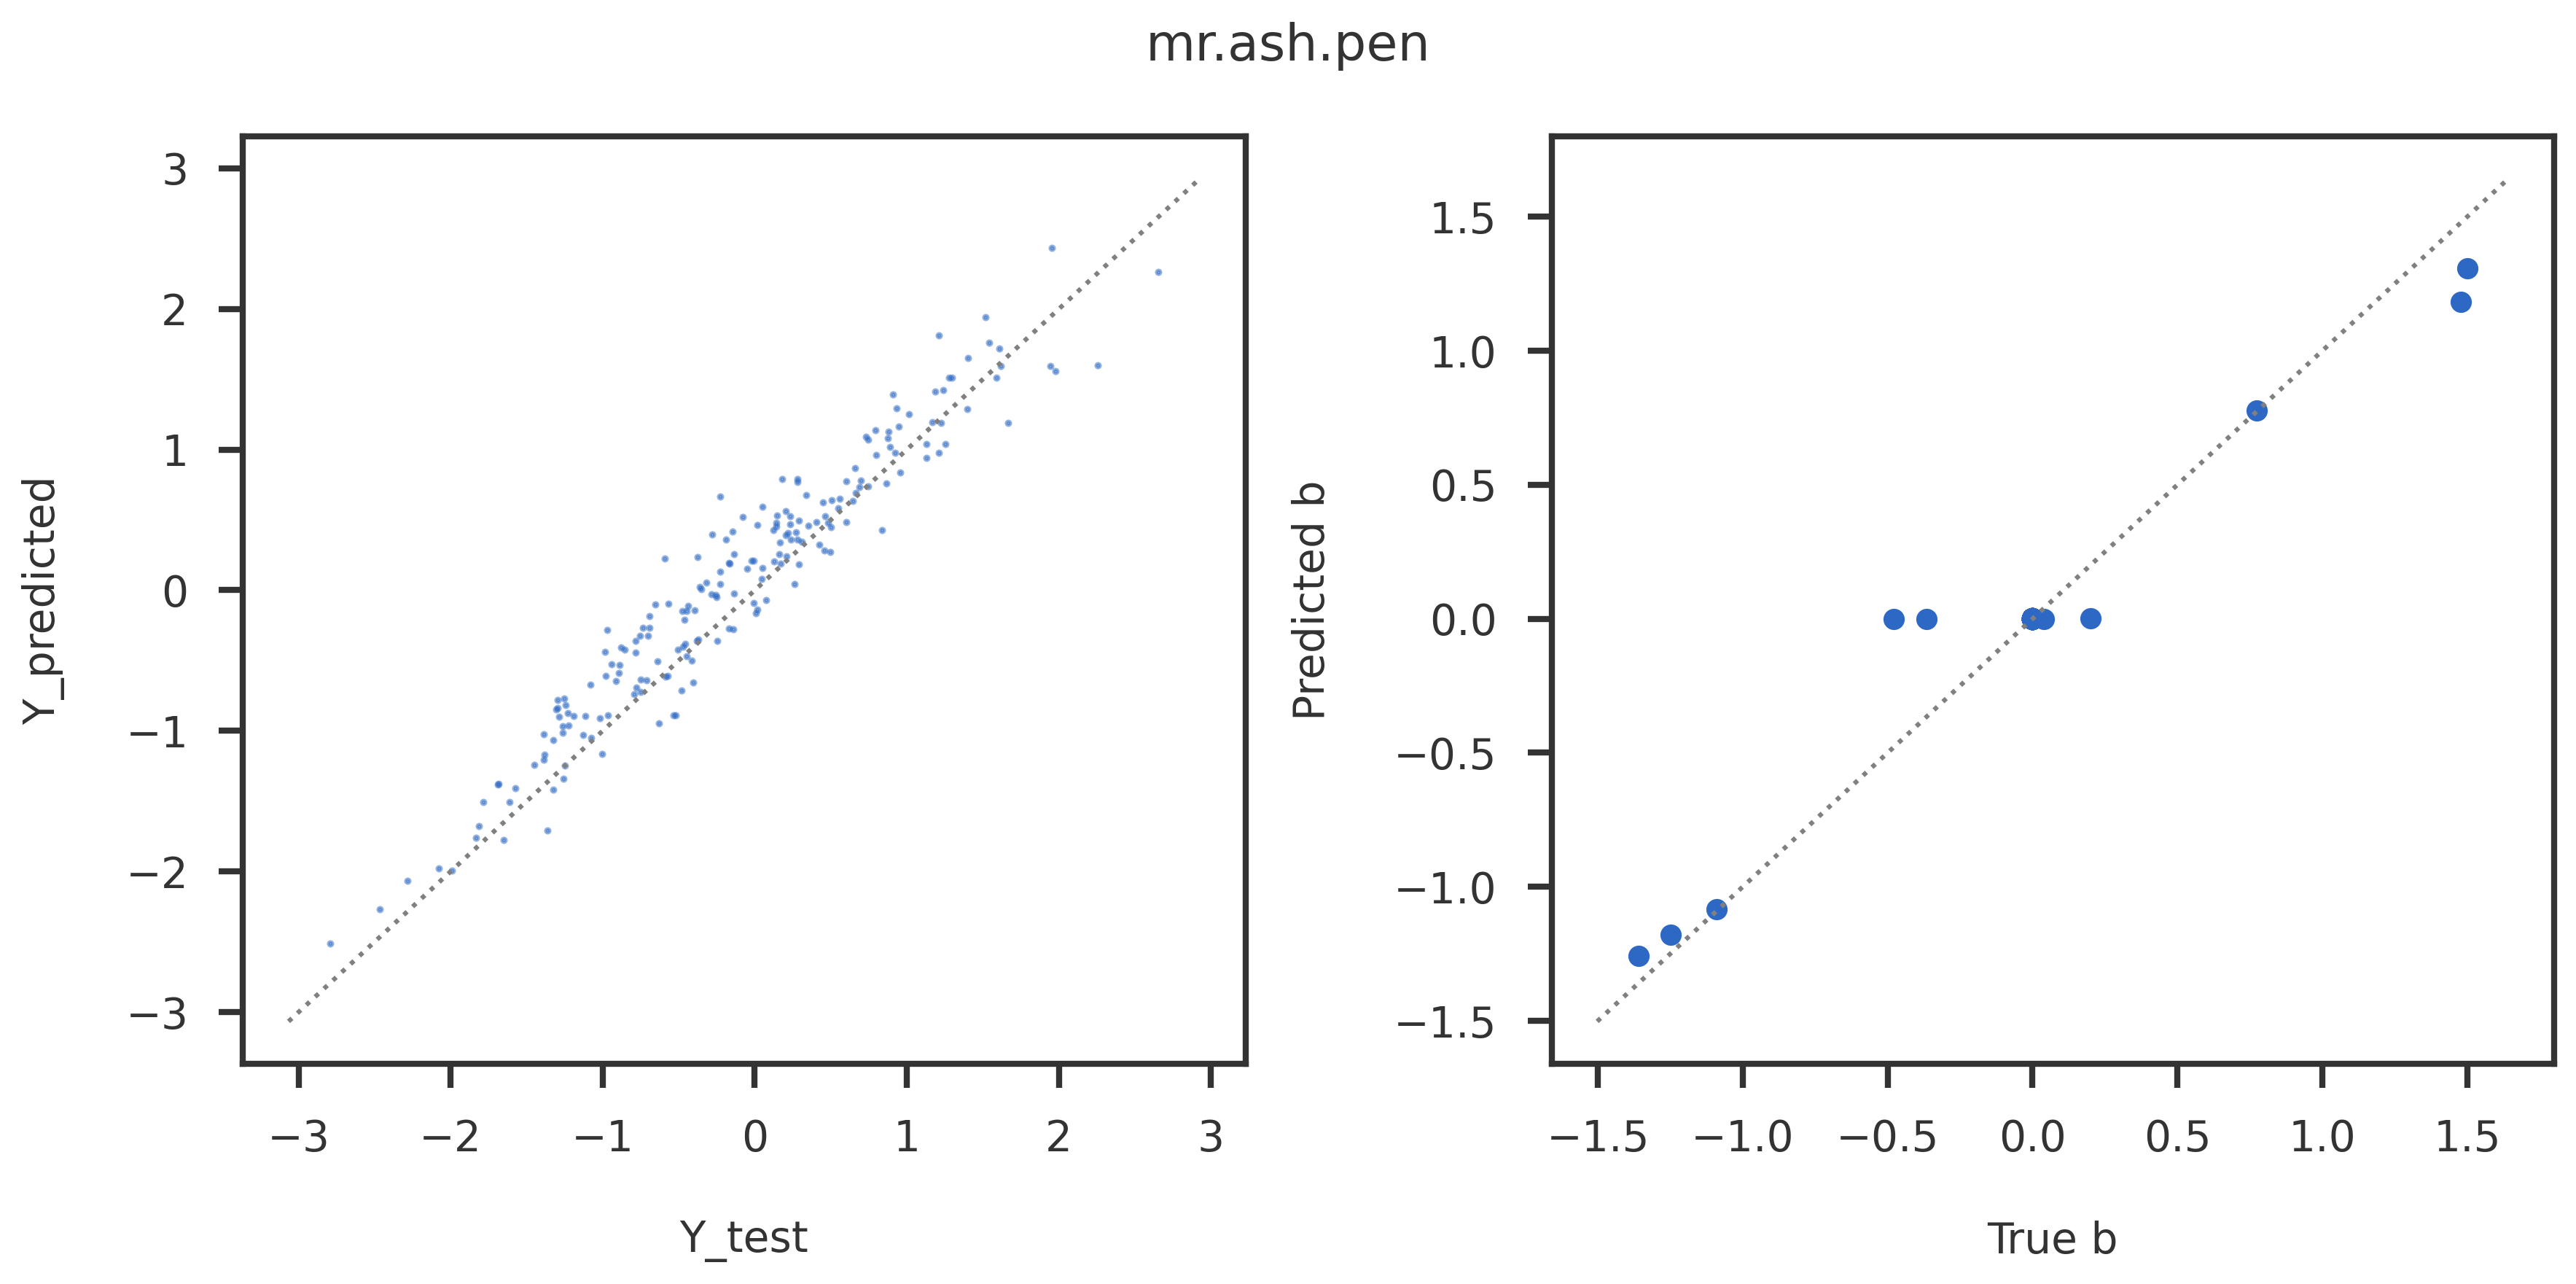

In [43]:
# lasso_a0, lasso_b, _ = R_lasso.fit(X, y)
s2init = np.var(y - np.dot(X, lasso_b) - lasso_a0)
# wk_pen, sk_pen = initialize_ash_prior(k, scale = 3)

plr_debug2 = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = True, is_prior_scaled = True,
                 debug = False, display_progress = False, calculate_elbo = False)
# plr_debug.fit(X, y, sk, binit = mrash_r.coef, winit = wk, s2init = mrash_r.residual_var)
plr_debug2.fit(X, y, sk, binit = plr_debug.theta, winit = wk, s2init = None, unshrink_binit = False)


from mrashpen.inference import coordinate_descent_step as cd_step
print(cd_step.elbo(X, y, sk, plr_debug2.coef, plr_debug2.prior, plr_debug2.residual_var))
print(plr_debug2.residual_var)

plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_debug2.coef, intercept = plr_debug2.intercept, title = 'mr.ash.pen')

In [42]:
plr_debug.coef[btrue != 0]

array([ 1.20743012e+00, -1.16402958e+00, -1.15075239e+00, -1.08434988e+00,
        4.97583423e-04,  1.42188798e-03, -1.62112159e-03, -4.61303735e-01,
        1.33821922e+00,  7.59667638e-01])

In [40]:
btrue[btrue != 0]

array([ 1.4773462 , -1.35937268, -1.24753798, -1.09007492,  0.03967675,
        0.19895889, -0.36673769, -0.48007765,  1.49958577,  0.77390471])

In [31]:
theta_init = plr_debug.b_to_theta(lasso_b)
theta_init[np.abs(theta_init) > 0.1]

array([ 1.16046573, -1.09053993, -1.10943842, -0.98144017, -0.31915581,
        1.32948565,  0.67631046])

In [ ]:
theta_init = plr_debug.b_to_theta(lasso_b)

In [23]:
btrue[btrue != 0]

array([ 1.4773462 , -1.35937268, -1.24753798, -1.09007492,  0.03967675,
        0.19895889, -0.36673769, -0.48007765,  1.49958577,  0.77390471])

In [27]:
plr_debug.theta[np.abs(plr_debug.coef) > 0.1]

array([ 1.27040697, -1.24784556, -1.13707757, -1.00033998,  1.46790571])

In [17]:
plr_debug.prior

array([0.21024007, 0.17700708, 0.12482855, 0.0890079 , 0.06689034,
       0.05257745, 0.04271246, 0.0355502 , 0.03015178, 0.02597327,
       0.02266578, 0.01999086, 0.01778389, 0.01593113, 0.01435254,
       0.01299014, 0.01180068, 0.01075132, 0.00981684, 0.0089777 ])

In [10]:
np.var(y - np.mean(np.dot(X, lasso_b)))

44.659781019068674

In [6]:
np.var(y - np.dot(X, lasso_b) - lasso_a0)

0.4066349738762403

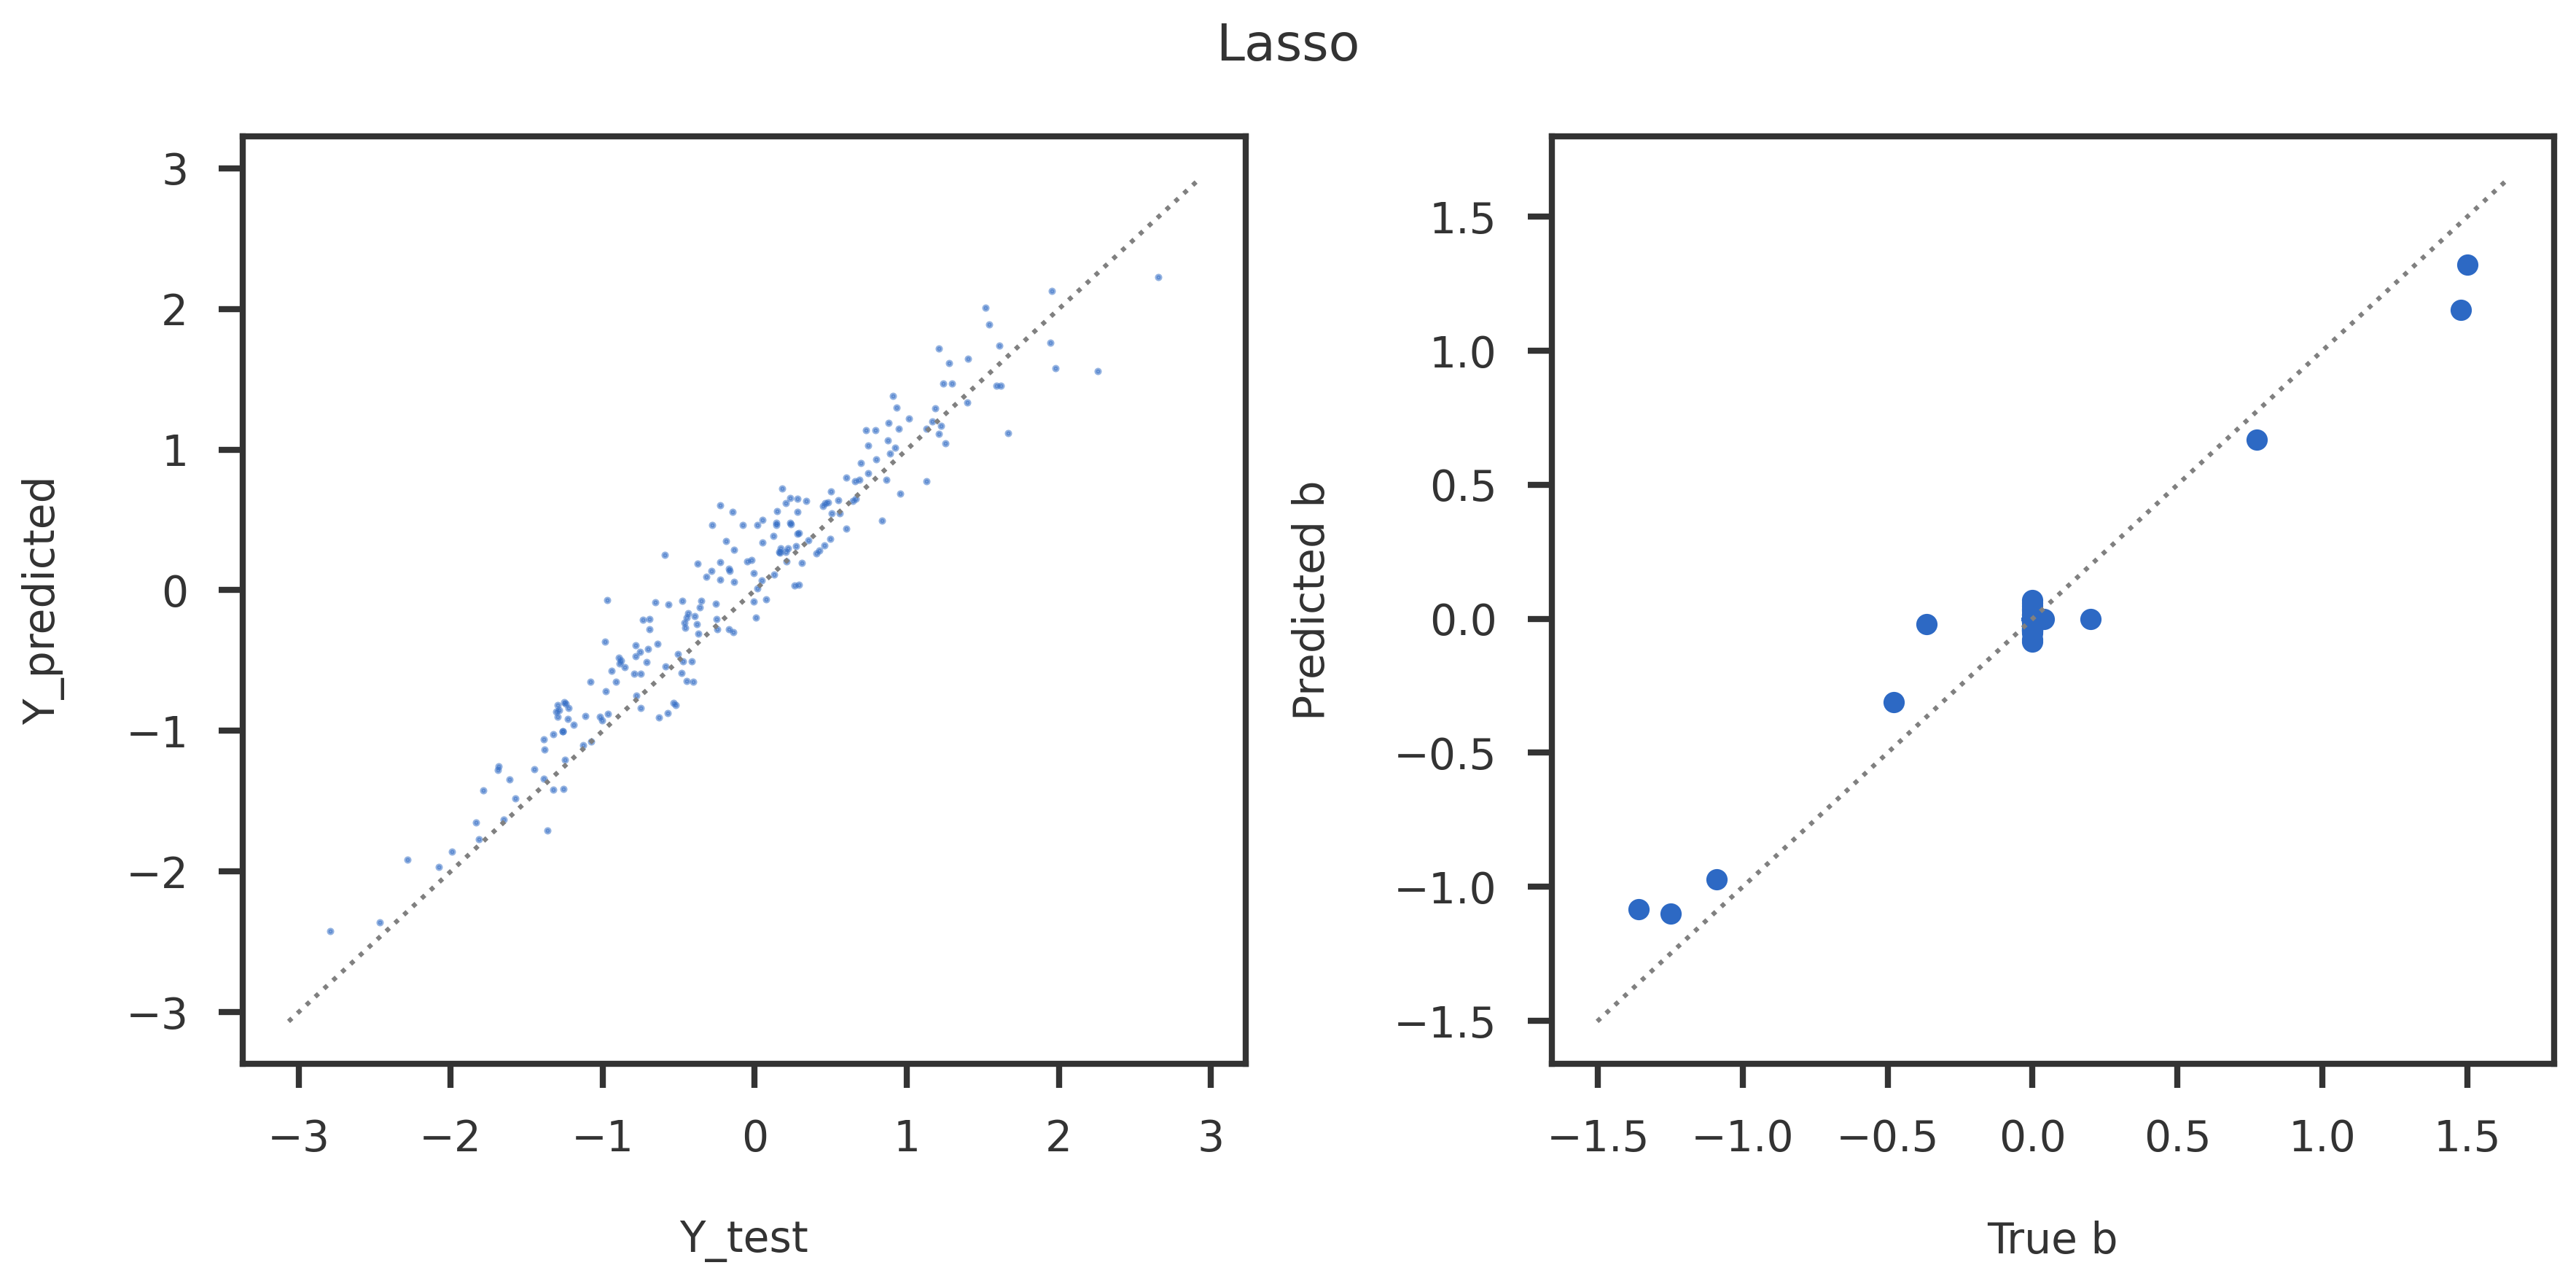

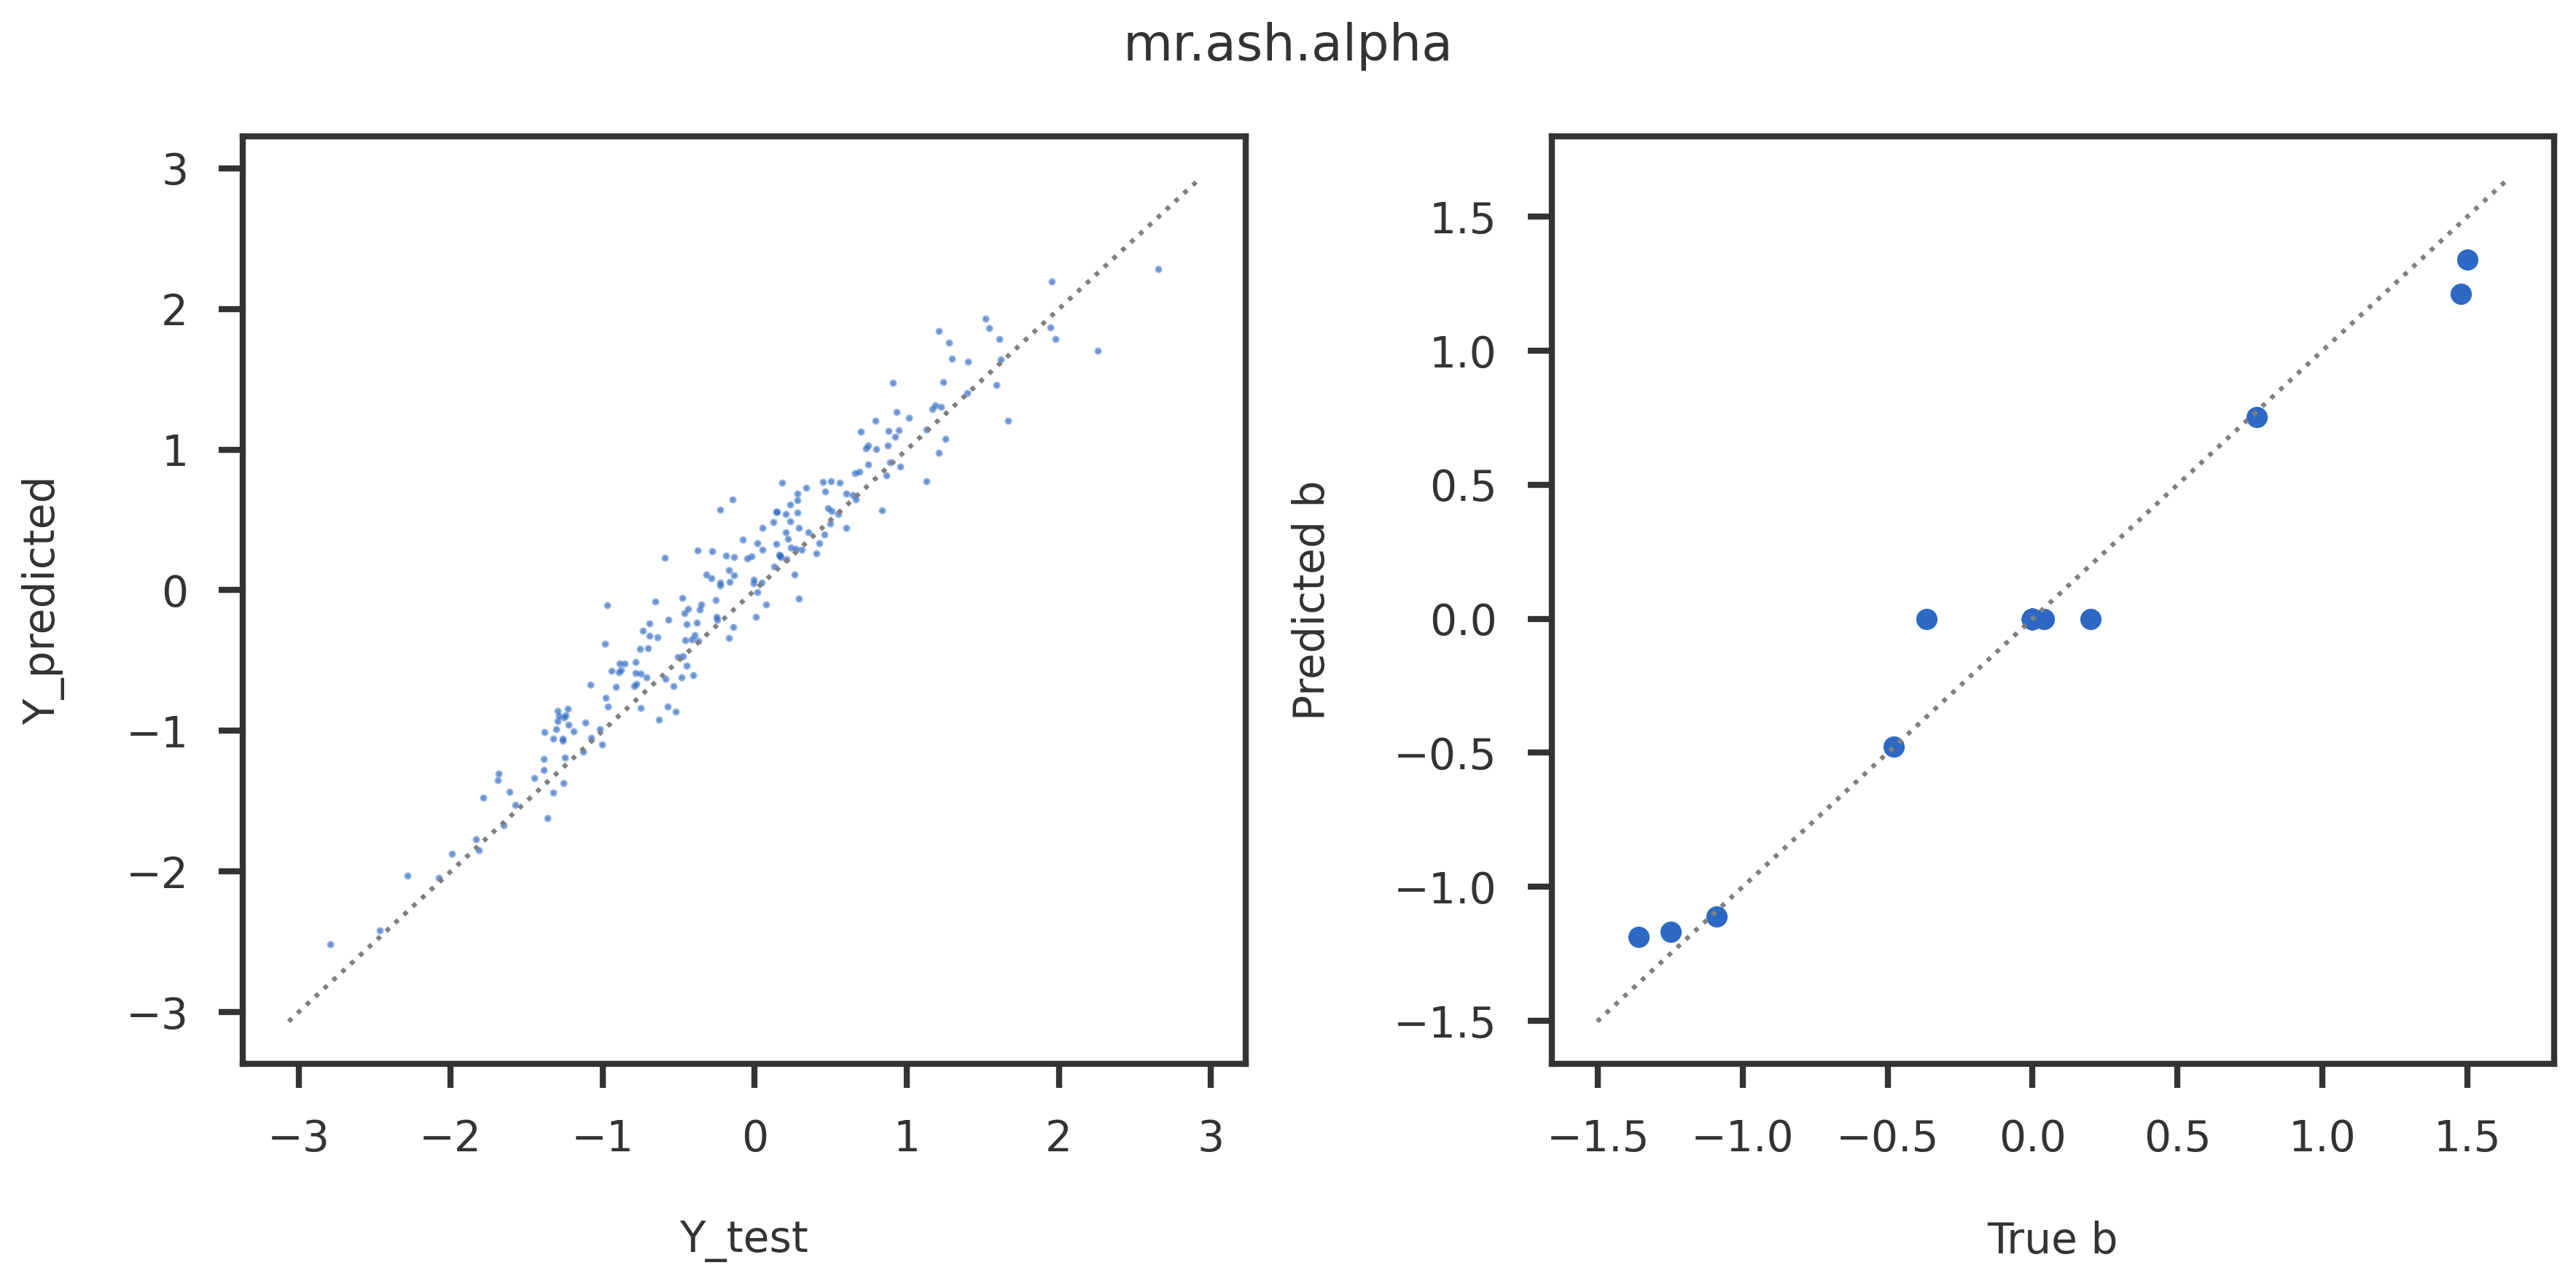

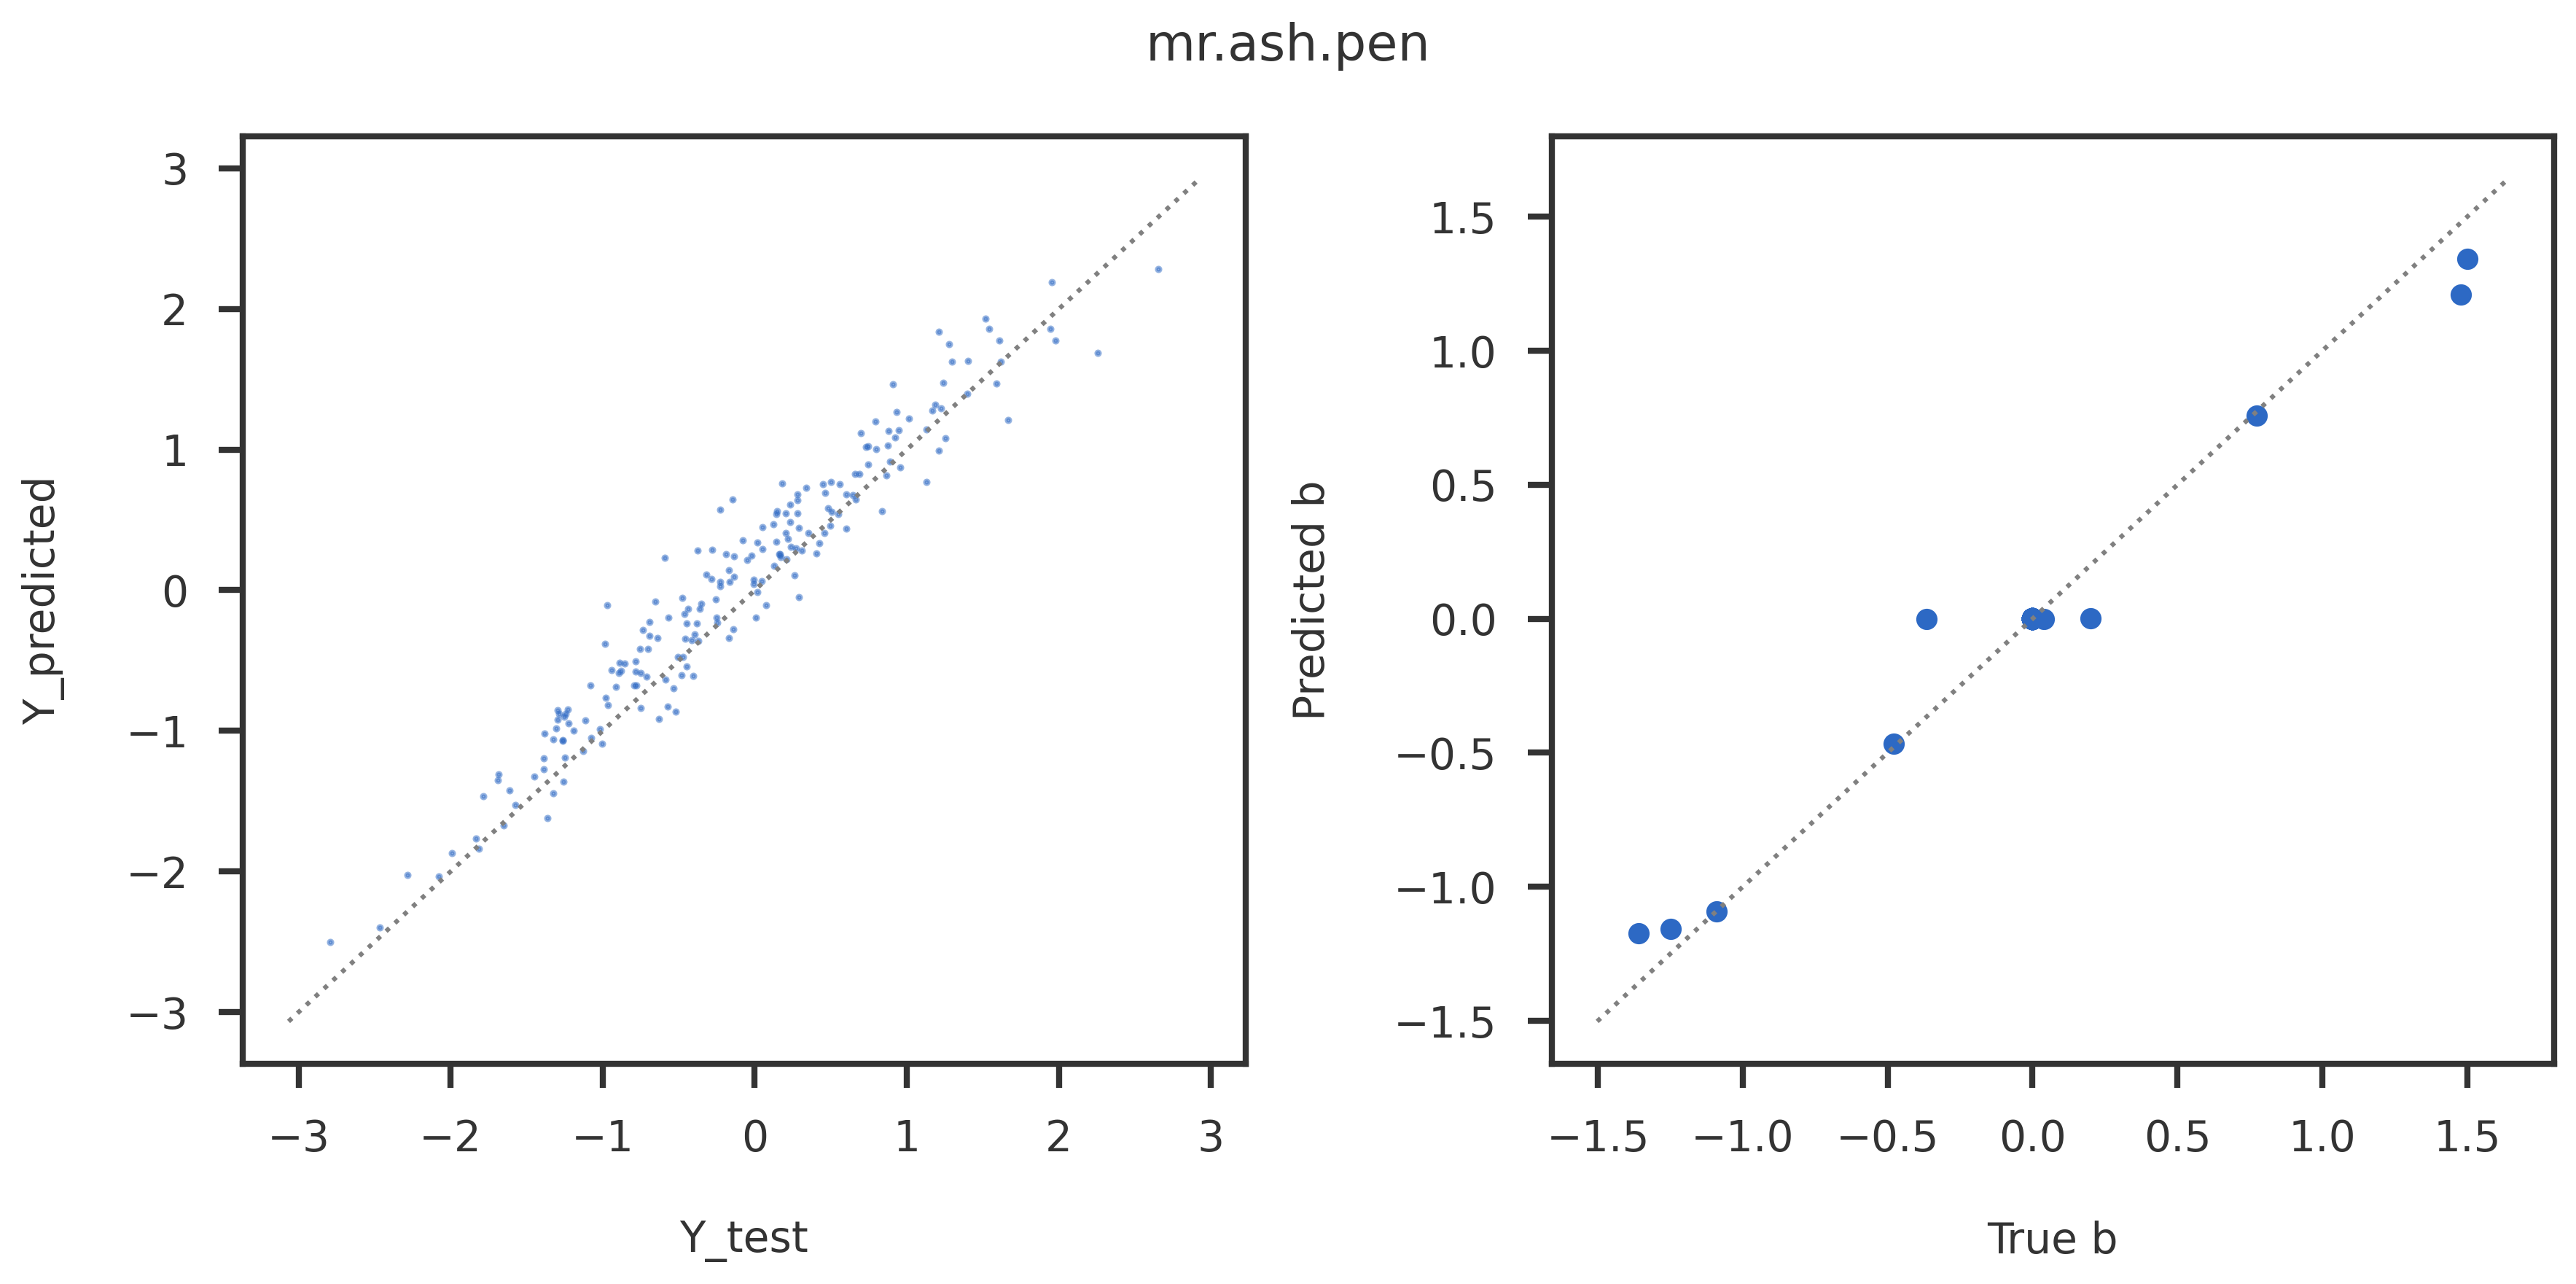

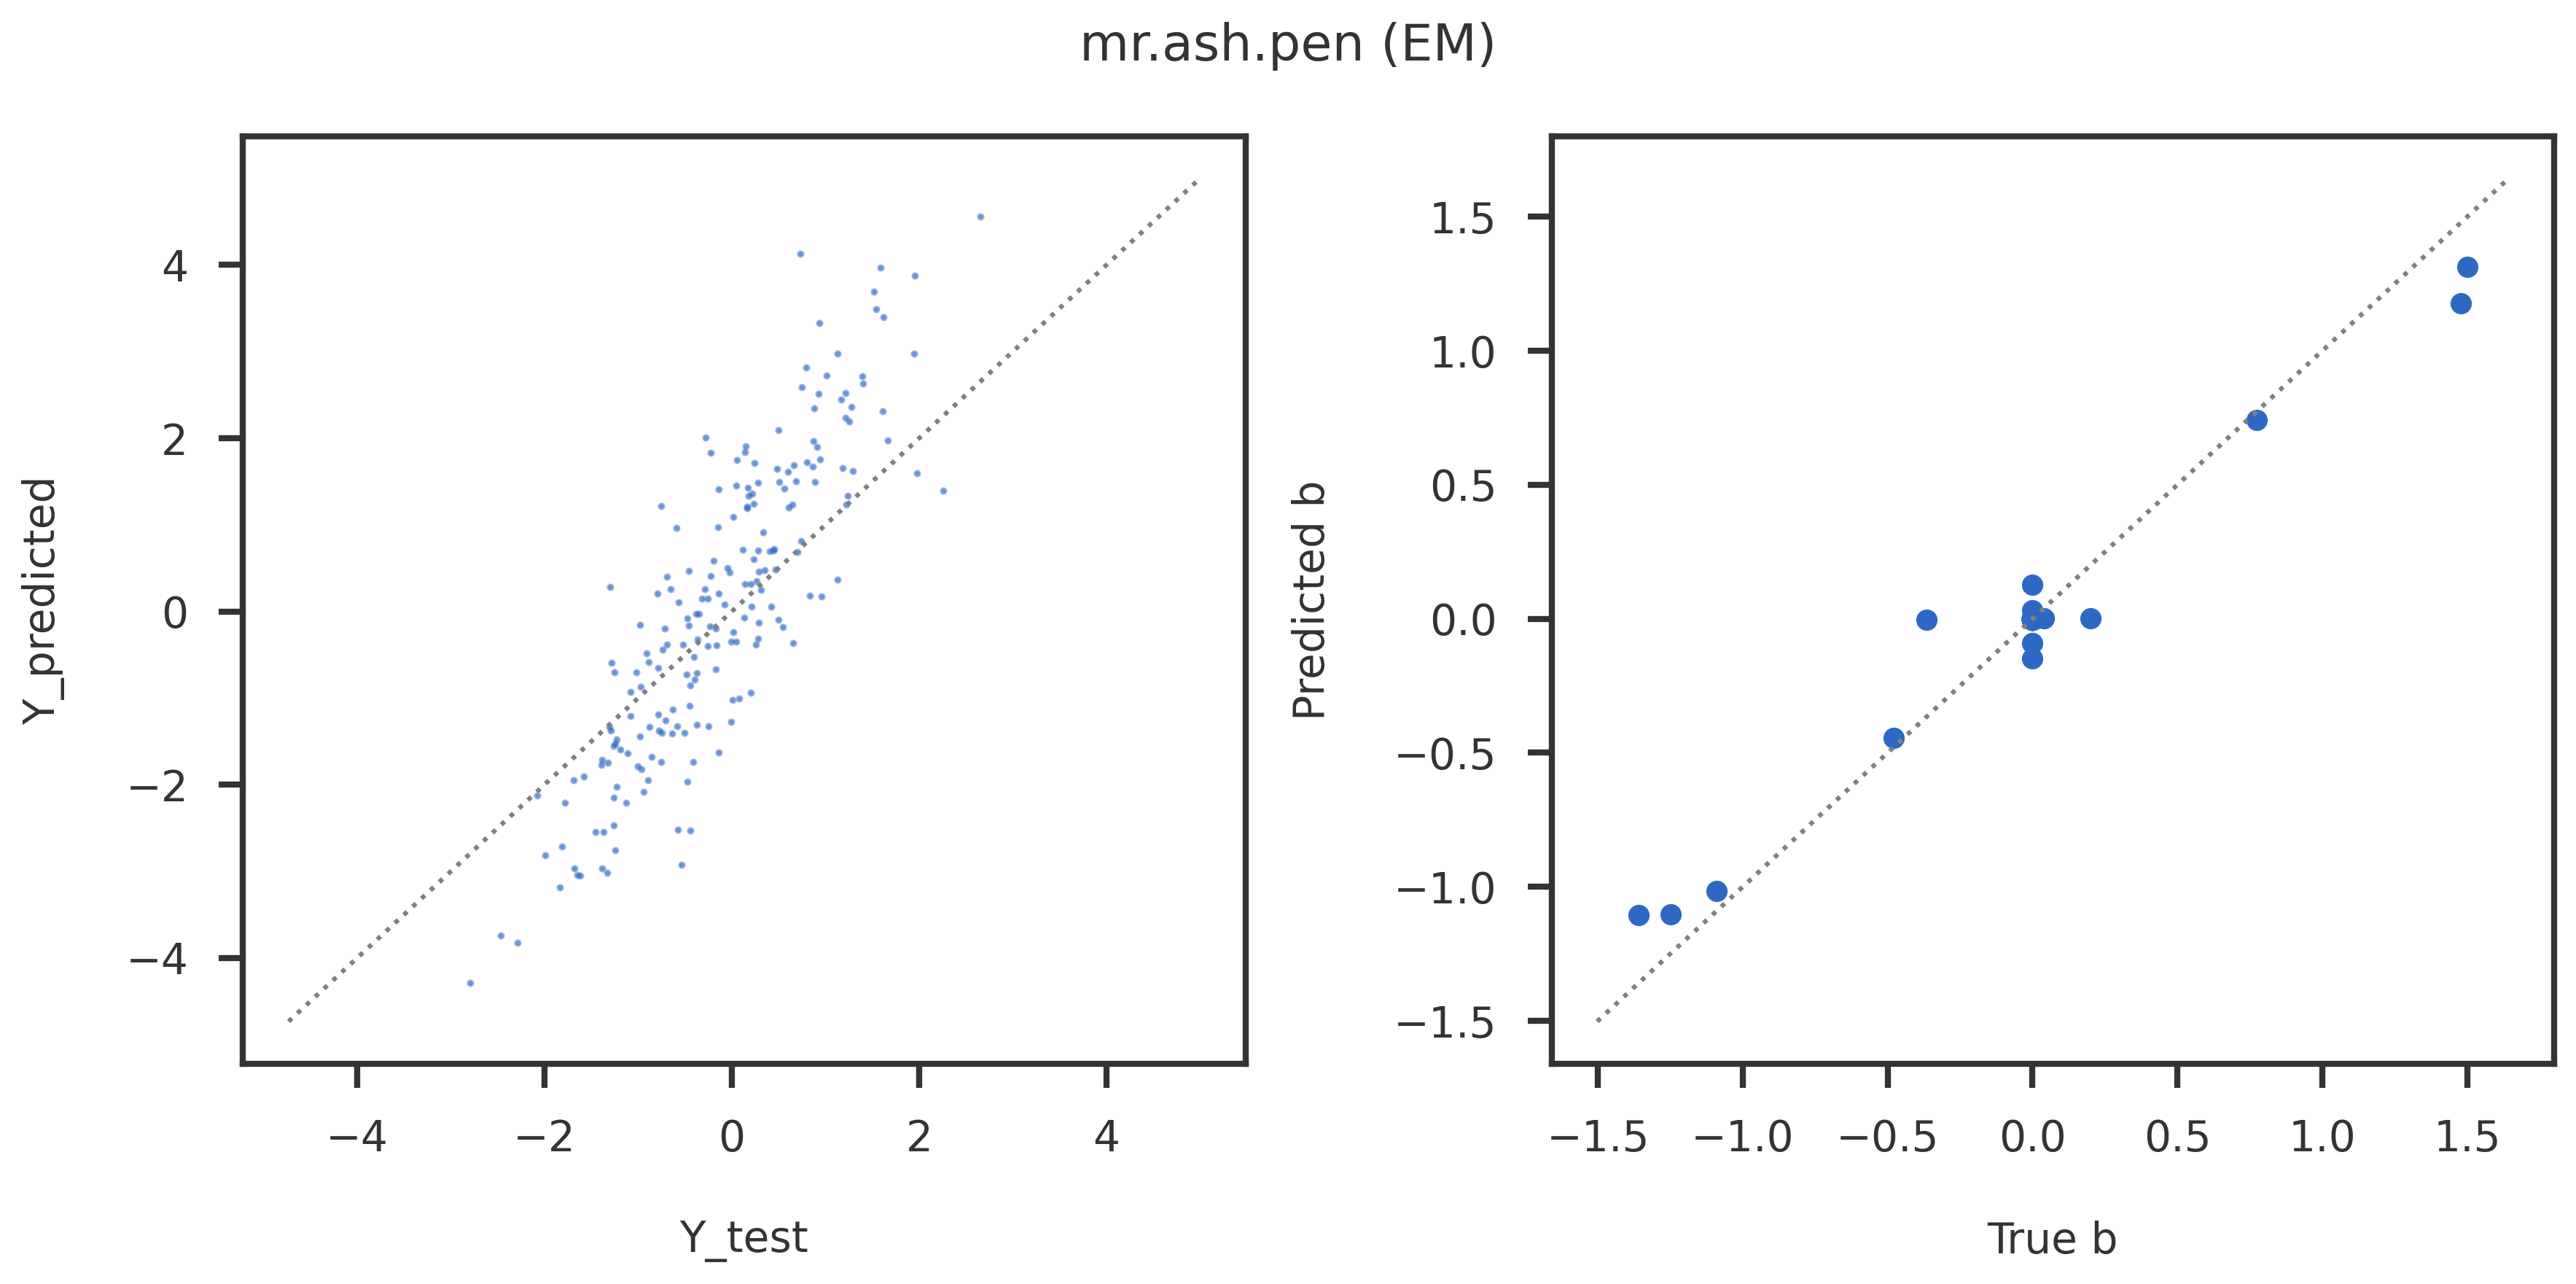

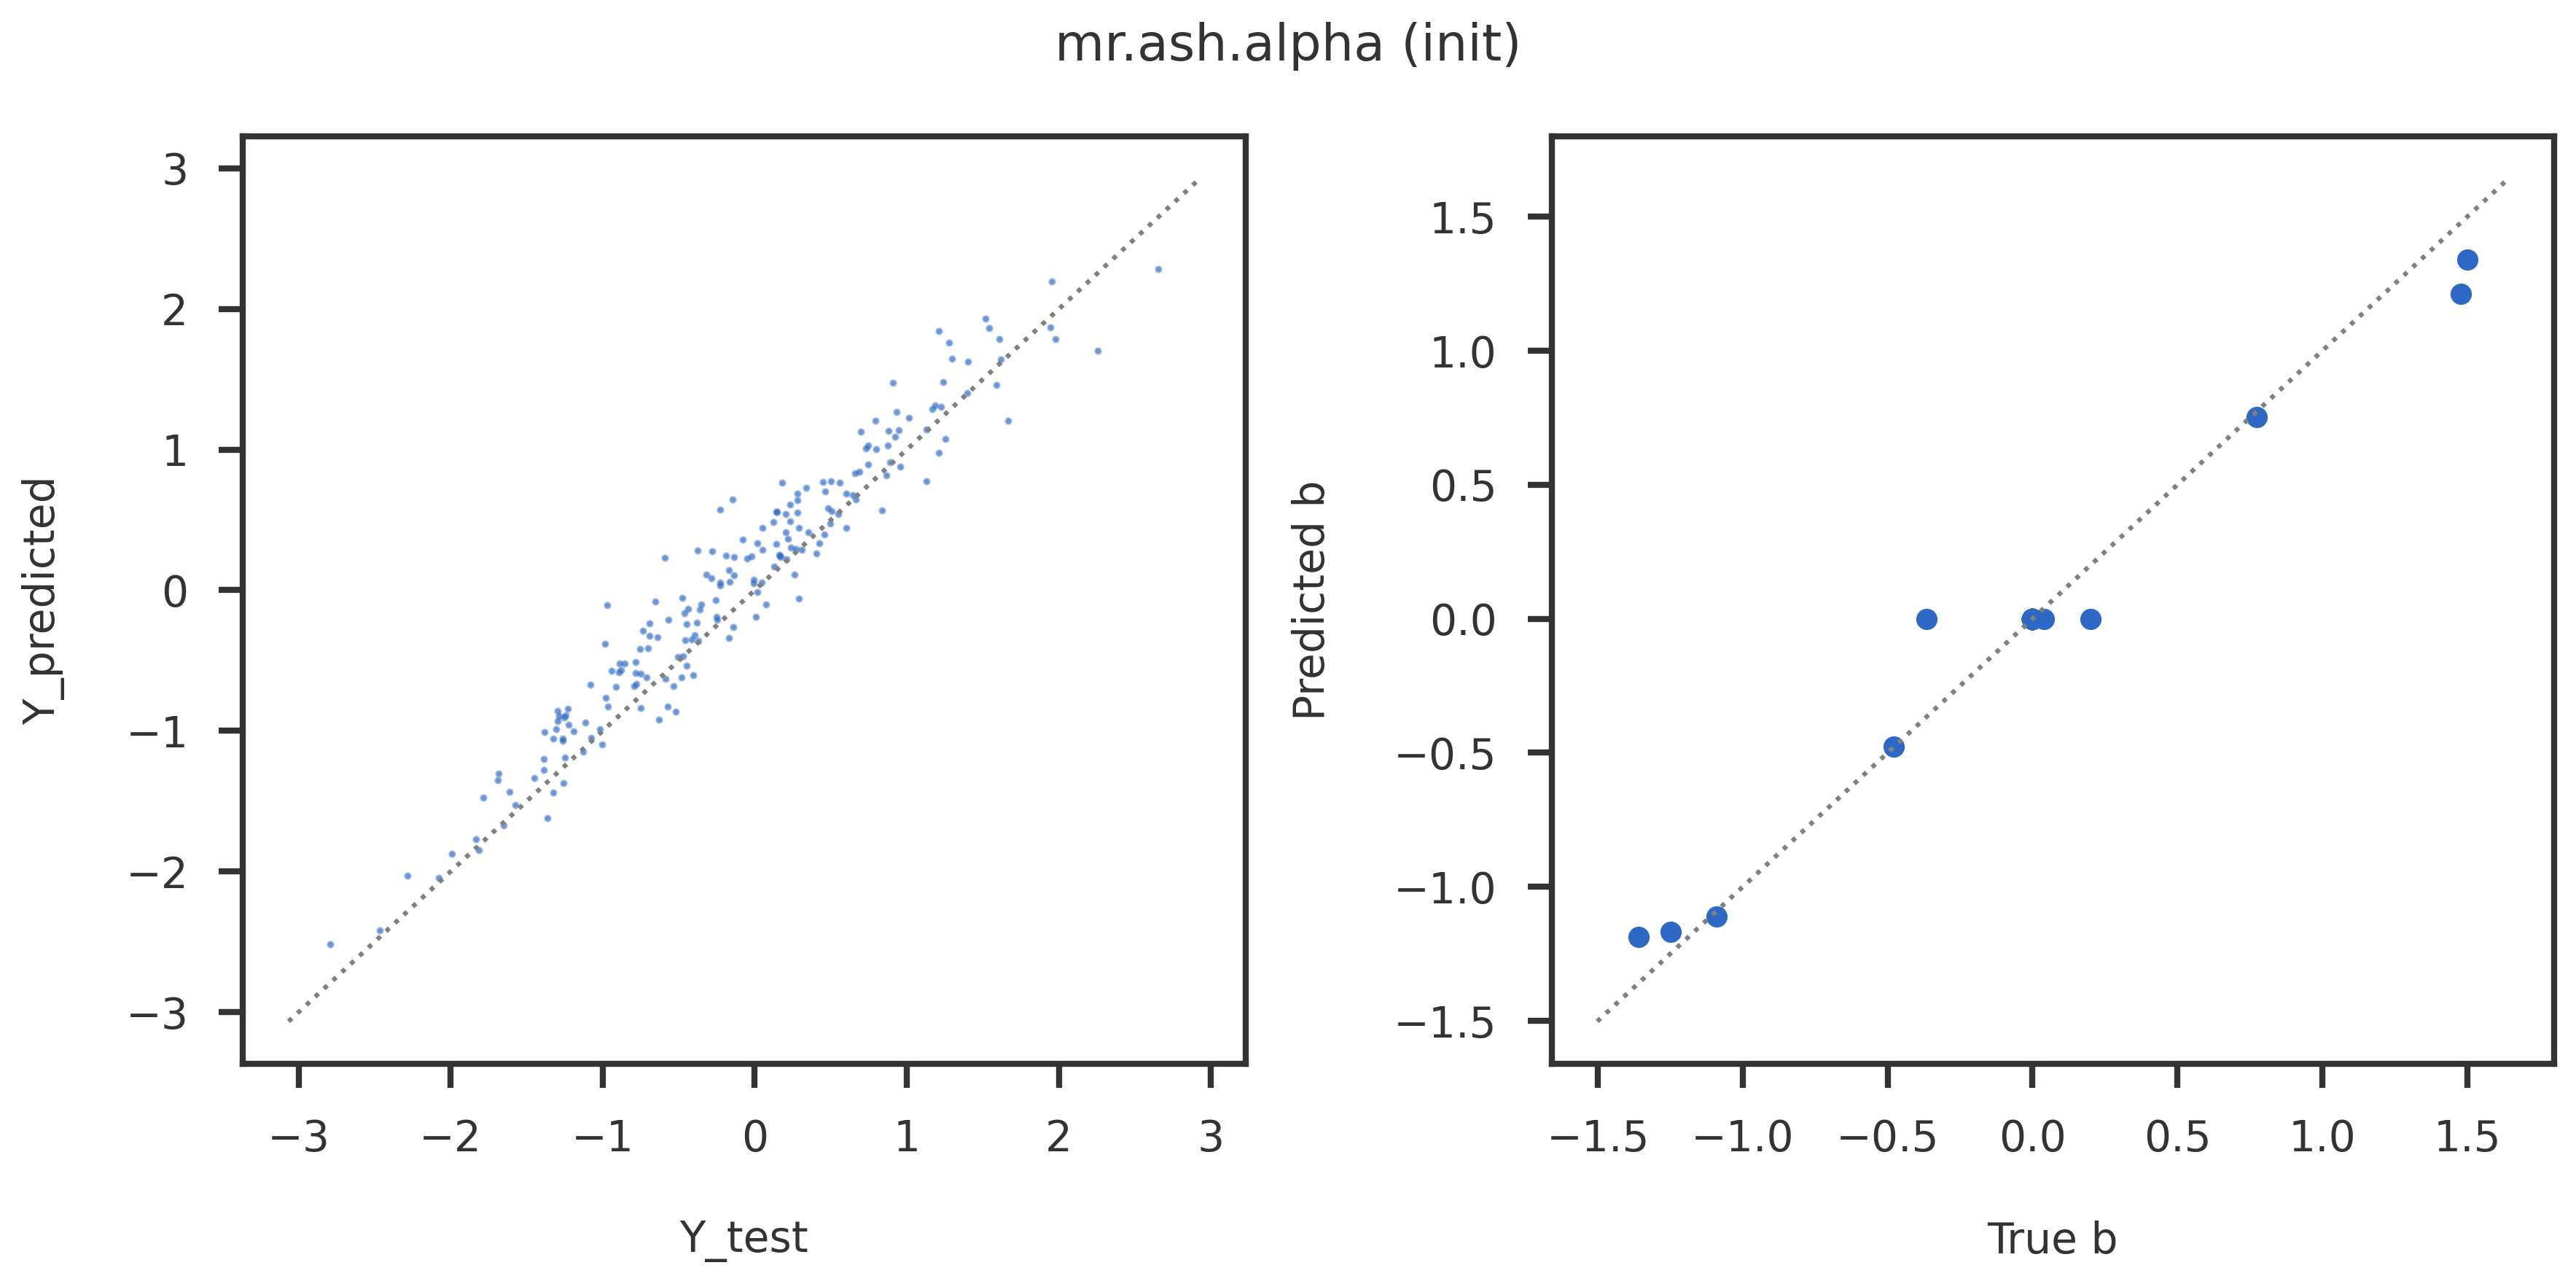

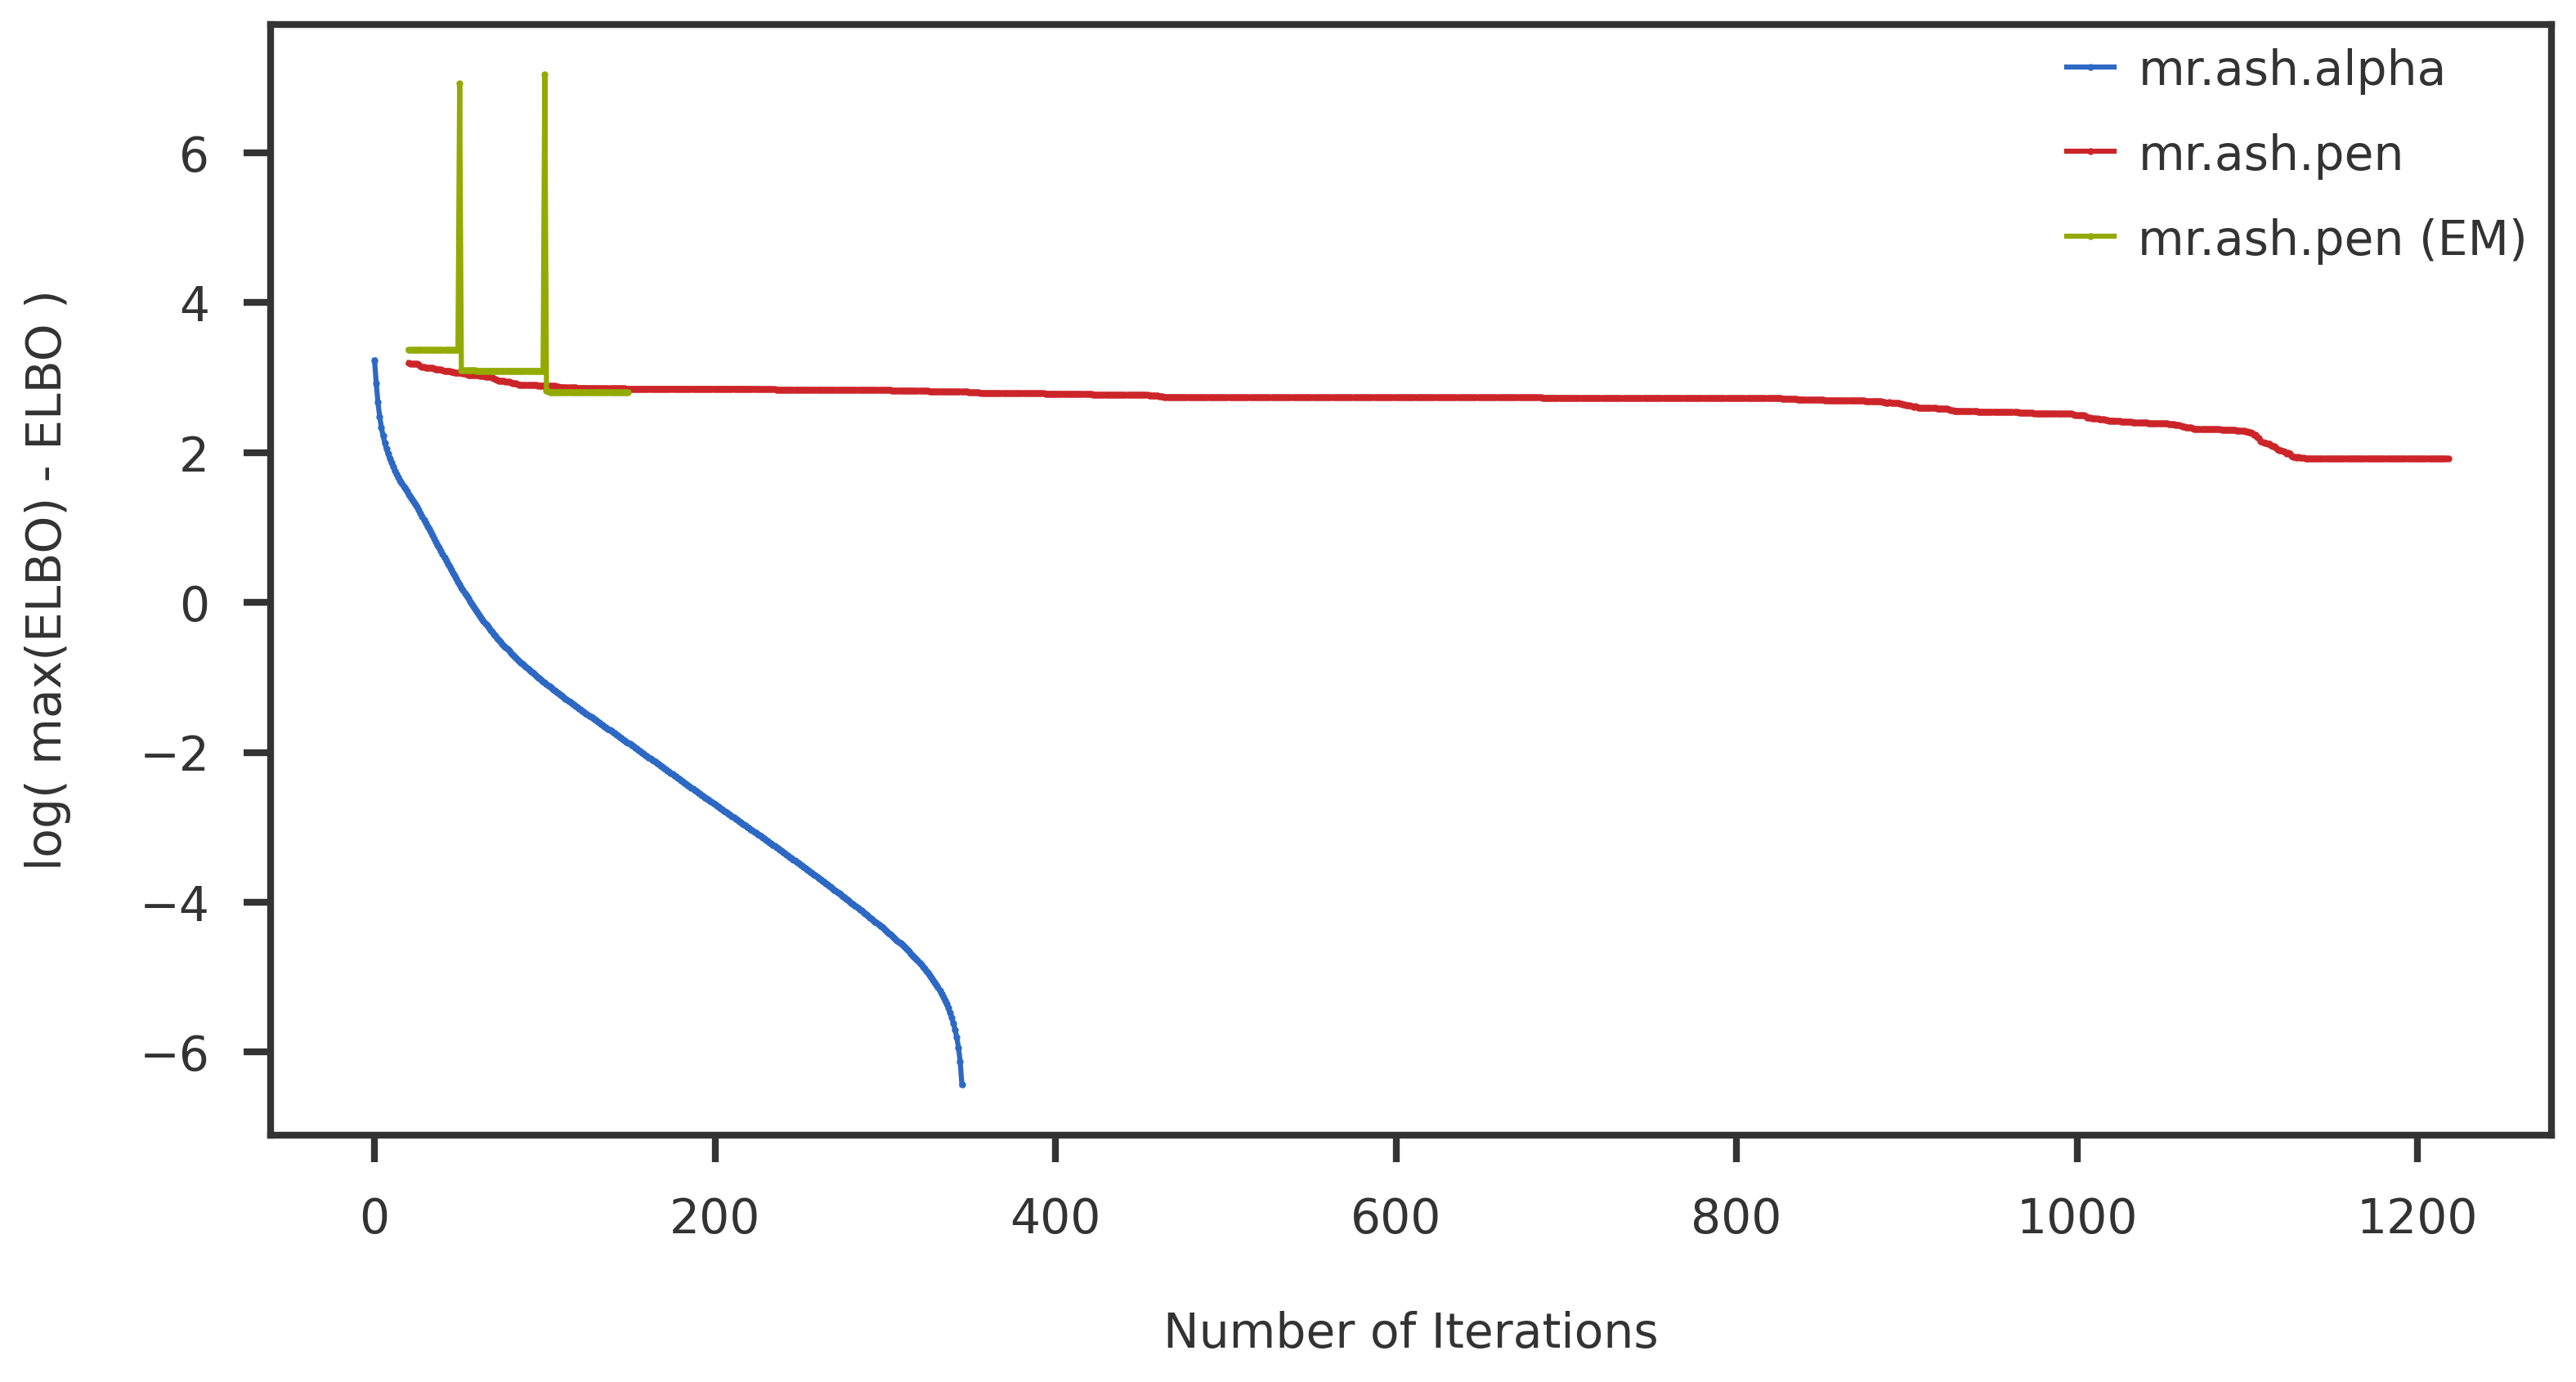

In [55]:
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     lasso_b, intercept = lasso_a0, title = 'Lasso')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue,
                     mrash_r.coef, intercept = mrash_r.intercept, title = 'mr.ash.alpha')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_lbfgs.coef, intercept = plr_lbfgs.intercept, title = 'mr.ash.pen')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_eb.coef, intercept = plr_eb.intercept, title = 'mr.ash.pen (EM)')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     mrash_r_init.coef, intercept = mrash_r_init.intercept, title = 'mr.ash.alpha (init)')

kinit   = [0, 20, 20, 0]
objs    = [mrash_r.obj_path, plr_lbfgs.elbo_path, plr_eb.elbo_path]
methods = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)"]
plot_convergence(objs, methods, kinit)

In [5]:
objs     = [mrash_r, plr_lbfgs, plr_eb, mrash_r_init]
methods  = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)", "mr.ash.alpha (init)"]
df       = linreg_summary_df(strue, objs, methods)
df

,sigma2,ELBO,niter
True,0.043211,-,-
mr.ash.alpha,0.104509,122.031837,347
mr.ash.pen,0.102486,205.370459,1219
mr.ash.pen (EM),0.063267,759.18091,150
mr.ash.alpha (init),0.104509,122.031838,191
